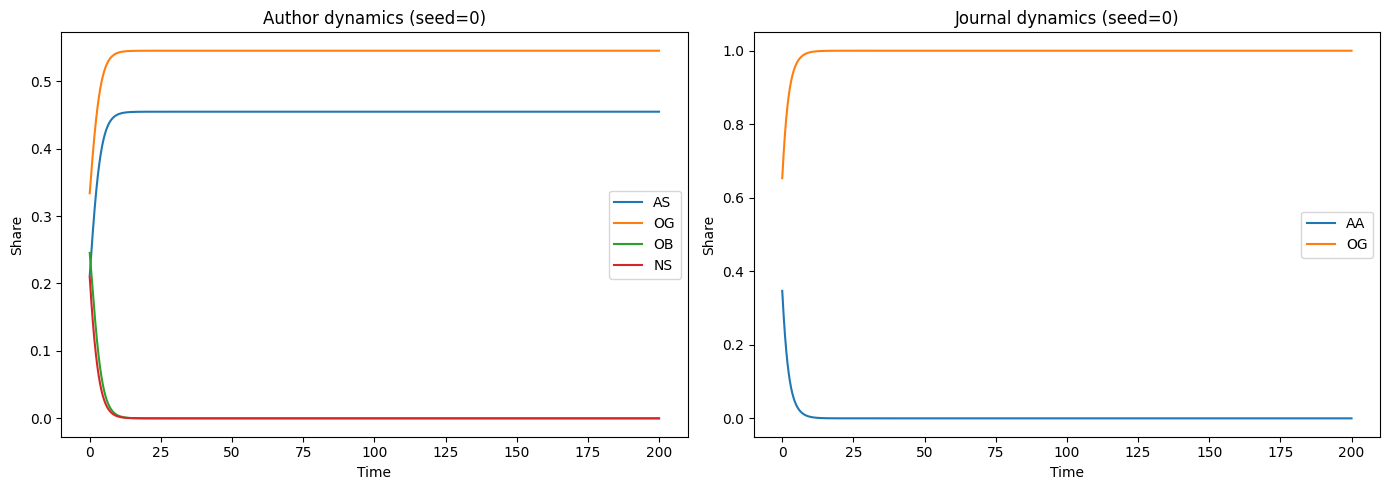

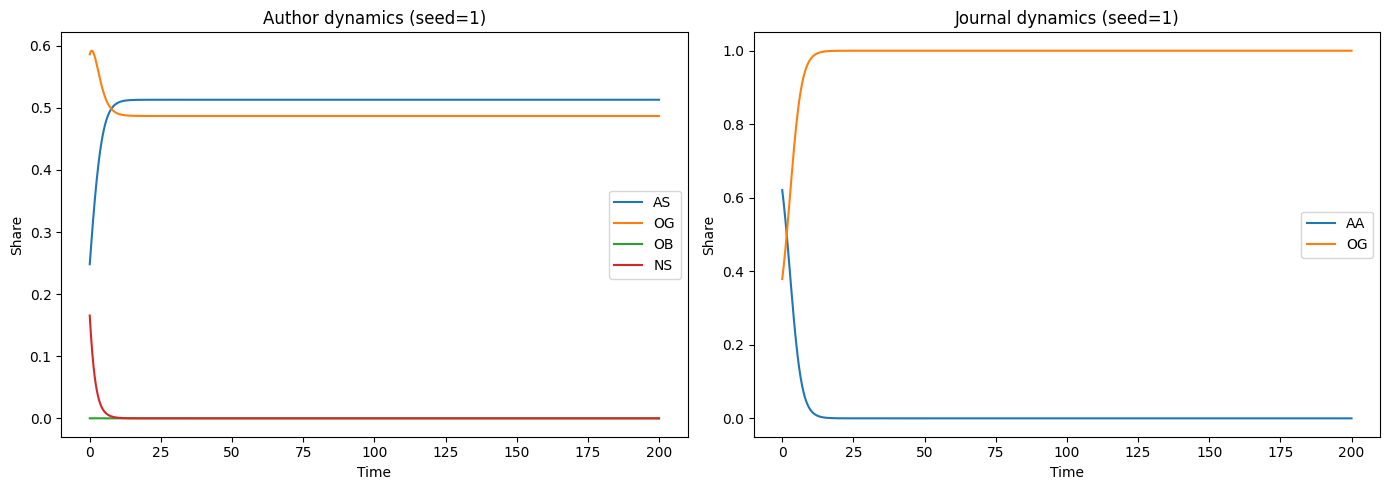

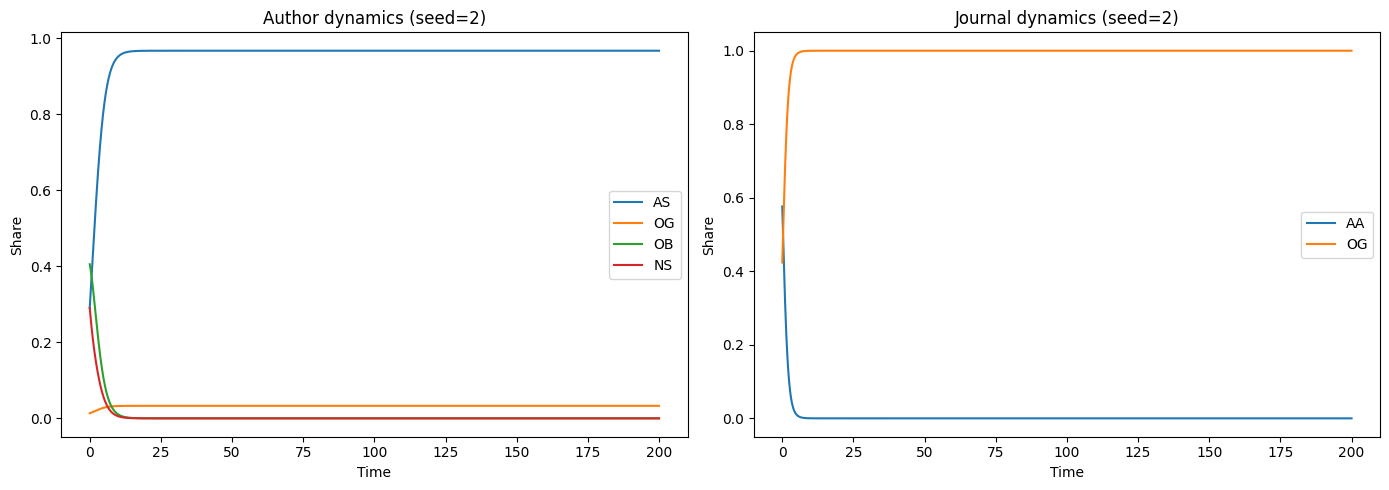

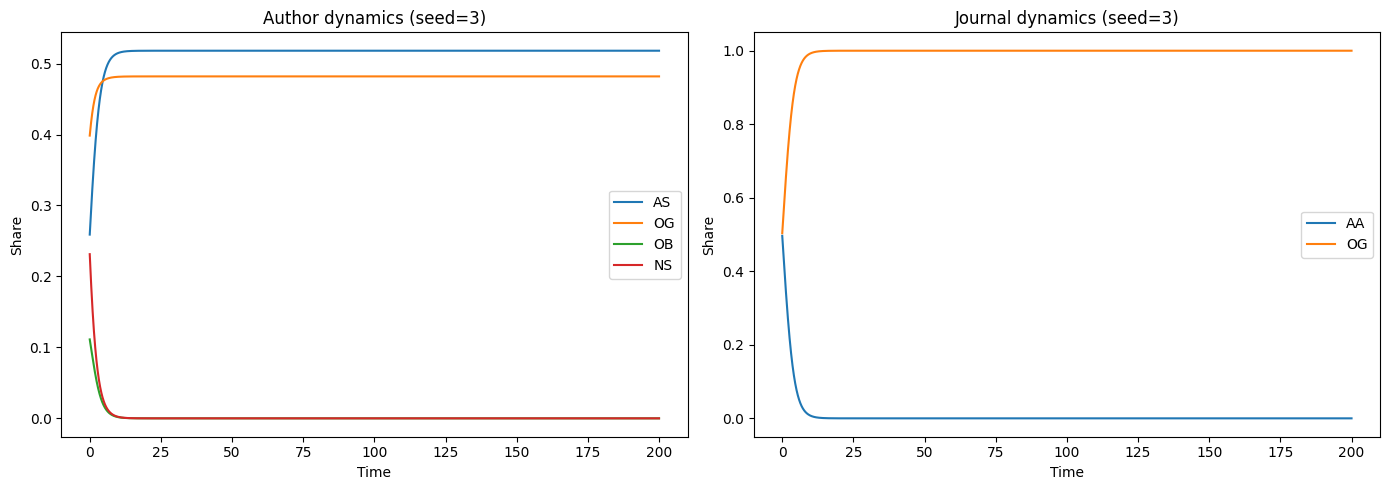

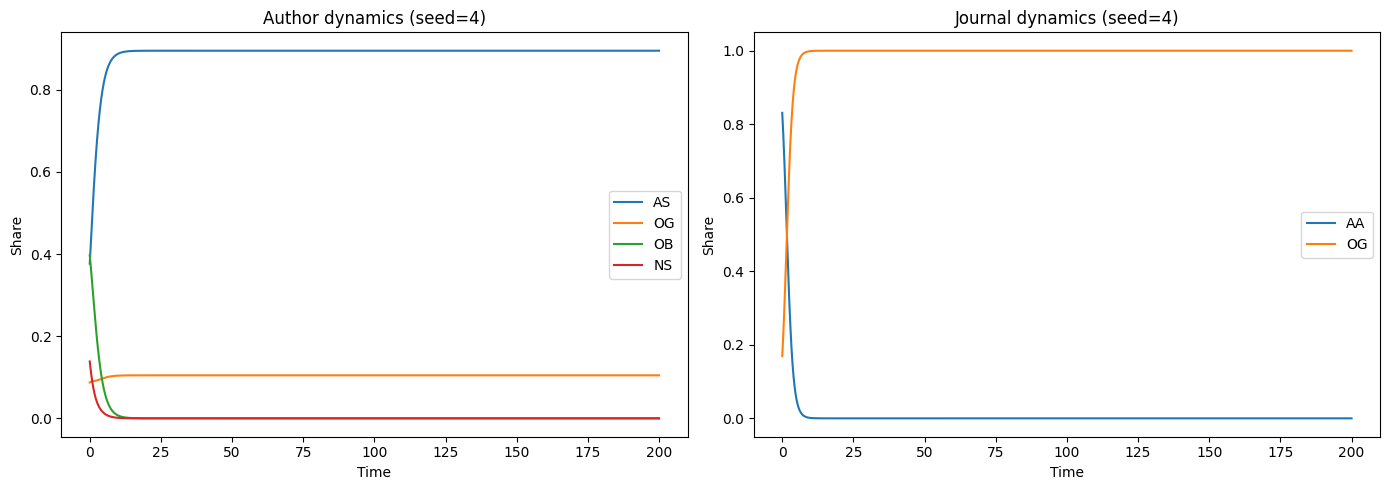

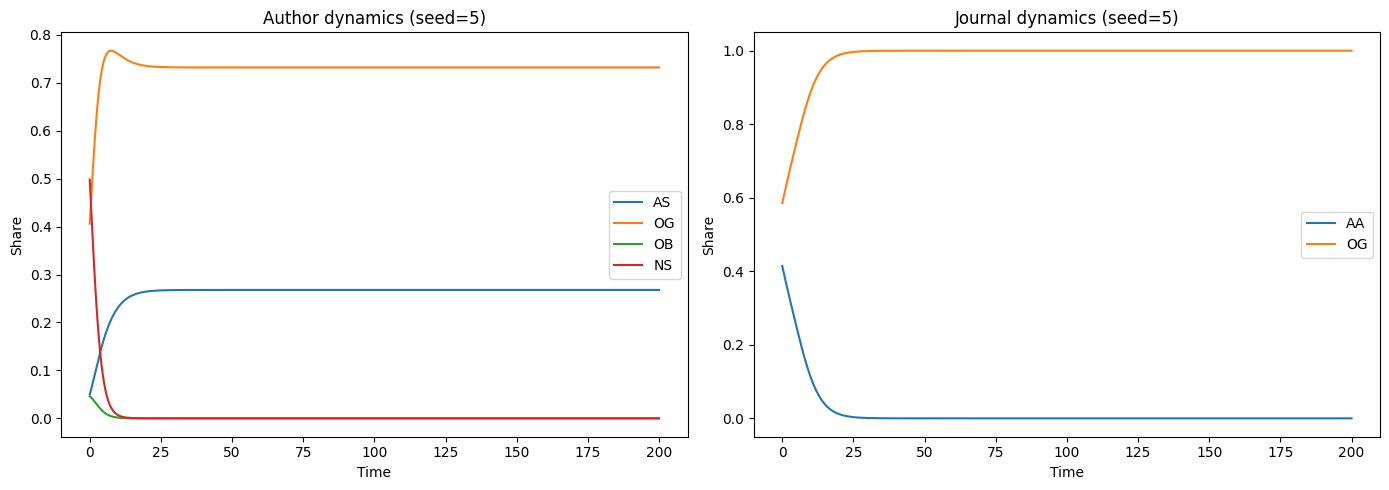

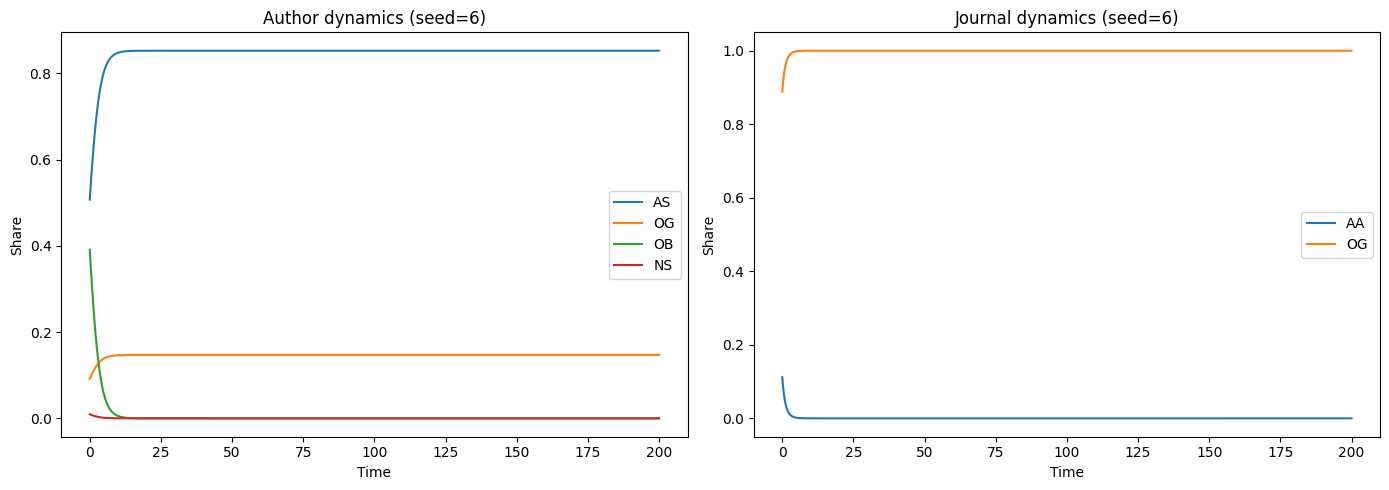

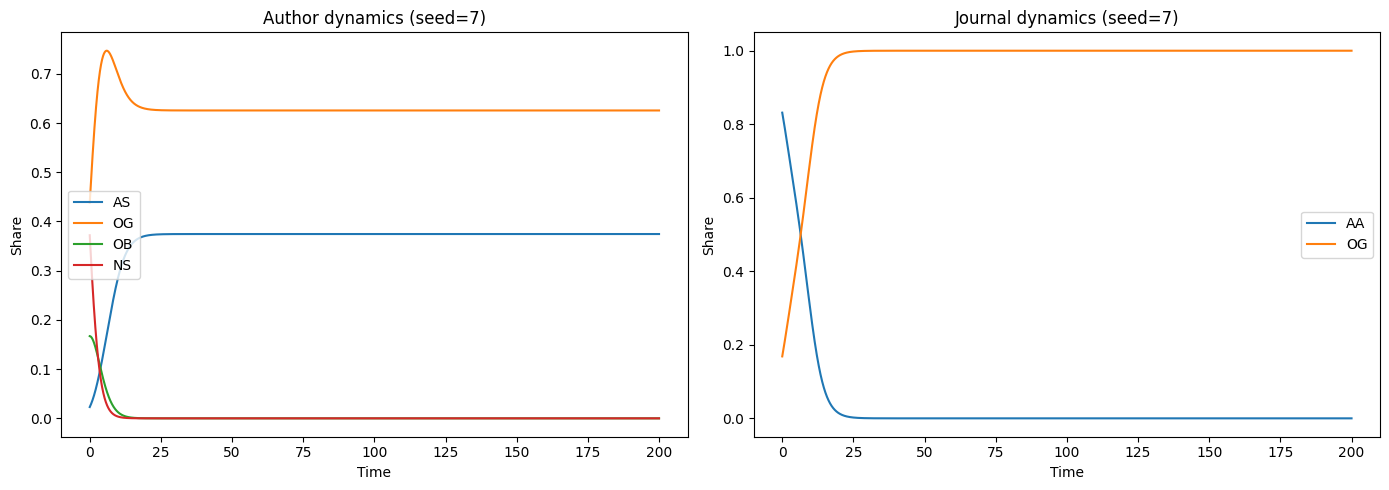

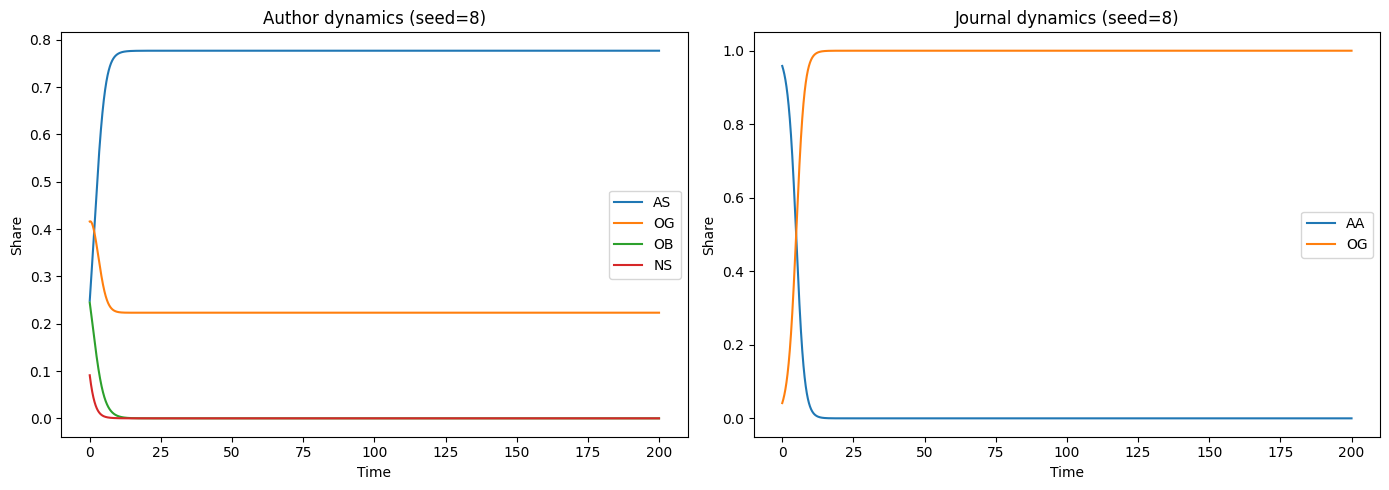

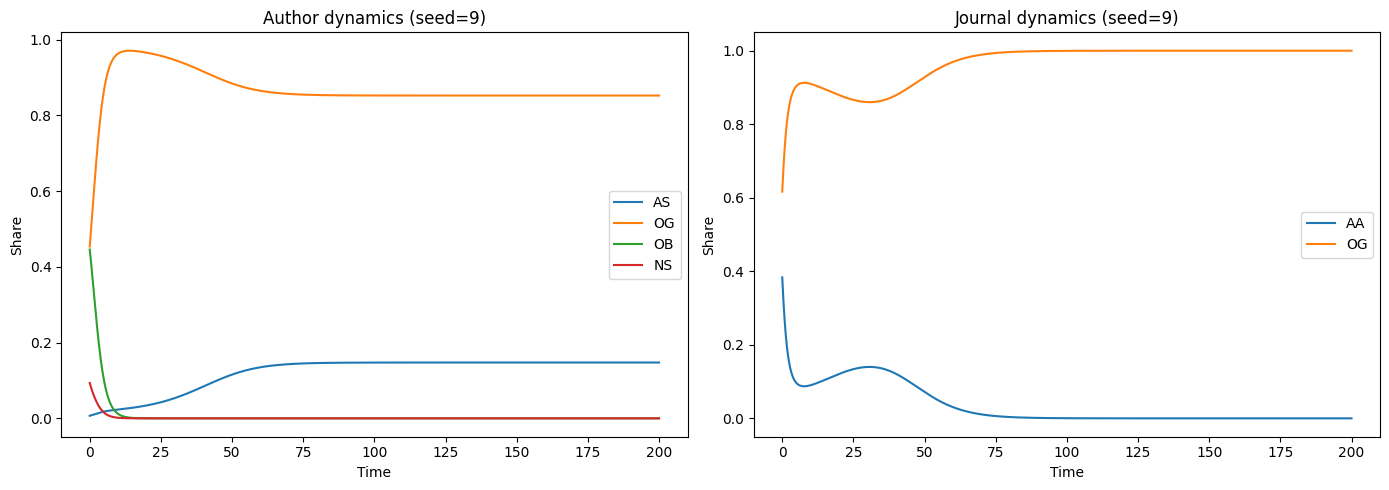

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =====================================
# 1. Parameters (same as your version)
# =====================================
alpha = 0.6
eps   = 0.1
lam   = 0.1

r     = 1.0
c     = 0.1

B     = 1.0
D     = 3

C_fix = 0.1
eta   = 0.5

N_A   = 5
N_J   = 1

strategies_A = ["AS", "OG", "OB", "NS"]
strategies_J = ["AA", "OG"]

# -------------------------------------
# 2. Helpers
# -------------------------------------
def pg_pb(s):
    if s == "AS":
        return alpha, 1 - alpha
    if s == "OG":
        return alpha, 0.0
    if s == "OB":
        return 0.0, 1 - alpha
    if s == "NS":
        return 0.0, 0.0
    raise ValueError("Unknown strategy")

def qg_qb(j):
    if j == "AA":
        return 1.0, 1.0
    if j == "OG":
        return 1.0 - eps, lam
    raise ValueError("Unknown strategy")

def author_payoff_given_j(j):
    qg, qb = qg_qb(j)
    u_list = []
    for s in strategies_A:
        pg, pb = pg_pb(s)
        u = r * (pg * qg + pb * qb) - c * (pg + pb)
        u_list.append(u)
    return np.array(u_list)

uA_AA = author_payoff_given_j("AA")
uA_OG = author_payoff_given_j("OG")


def S_G_B_from_x(x):
    x_AS, x_OG, x_OB, x_NS = x
    S = N_A * ( x_AS + alpha*x_OG + (1-alpha)*x_OB )
    G = N_A * alpha * (x_AS + x_OG)
    B_bad = N_A * (1-alpha) * (x_AS + x_OB)
    return S, G, B_bad

def journal_payoff(x, j):
    S, G, B_bad = S_G_B_from_x(x)
    if j == "AA":
        A_good = G
        A_bad  = B_bad
    else:
        A_good = (1-eps) * G
        A_bad  = lam * B_bad
    norm_term  = (B*A_good - D*A_bad)/(S+1)
    cost_term  = C_fix * ( S / ((N_A/N_J)+1) ) ** eta
    return norm_term - cost_term

def journal_payoff_vector(x):
    return np.array([ journal_payoff(x,"AA"),
                      journal_payoff(x,"OG") ])


# -------------------------------------
# 3. Replicator step
# -------------------------------------
def replicator_step(x, y, dt=0.05):
    uA = y[0]*uA_AA + y[1]*uA_OG
    avg_uA = np.dot(x, uA)
    dx = x * (uA - avg_uA)
    x_new = x + dt*dx
    x_new = np.clip(x_new, 1e-12, None)
    x_new = x_new / x_new.sum()

    uJ = journal_payoff_vector(x)
    avg_uJ = np.dot(y, uJ)
    dy = y * (uJ - avg_uJ)
    y_new = y + dt*dy
    y_new = np.clip(y_new, 1e-12, None)
    y_new = y_new / y_new.sum()

    return x_new, y_new



def simulate(T=200, dt=0.01, seed=0):
    np.random.seed(seed)
    x = np.random.dirichlet(np.ones(4))
    y = np.random.dirichlet(np.ones(2))

    xs = [x]
    ys = [y]
    steps = int(T/dt)

    for _ in range(steps):
        x, y = replicator_step(x, y, dt)
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


# =====================================
# 4. Run 10 seeds and plot each
# =====================================
for seed in range(10):
    xs, ys = simulate(T=200, dt=0.01, seed=seed)
    t = np.linspace(0, 200, xs.shape[0])

    plt.figure(figsize=(14,5))

    # ------------ left subplot: authors
    plt.subplot(1,2,1)
    for i, label in enumerate(["AS","OG","OB","NS"]):
        plt.plot(t, xs[:,i], label=label)
    plt.title(f"Author dynamics (seed={seed})")
    plt.xlabel("Time")
    plt.ylabel("Share")
    plt.legend()

    # ------------ right subplot: journal
    plt.subplot(1,2,2)
    for i, label in enumerate(["AA","OG"]):
        plt.plot(t, ys[:,i], label=label)
    plt.title(f"Journal dynamics (seed={seed})")
    plt.xlabel("Time")
    plt.ylabel("Share")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"dynamics_seed_{seed}.png", dpi=300)
    plt.show()


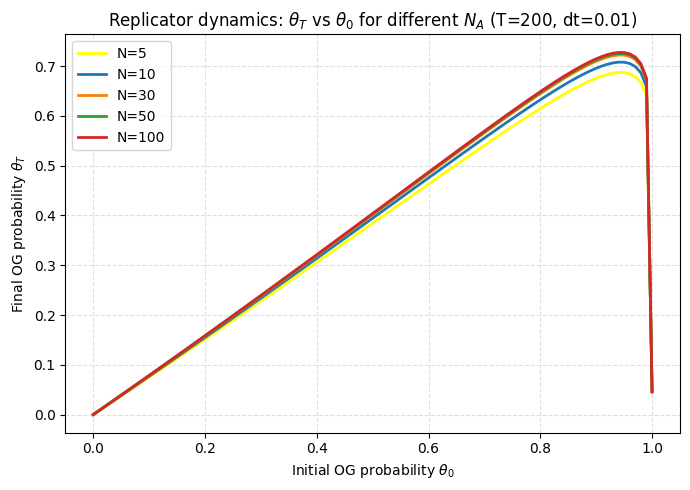

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


alpha = 0.6
eps   = 0.1
lam   = 0.1

r     = 1.0
c     = 0.1

B     = 1.0
D     = 3.0

C_fix = 0.1
eta   = 0.5

N_A   = 5
N_J   = 1


def pg_pb(s):
    if s == "AS":
        return alpha, 1 - alpha
    if s == "OG":
        return alpha, 0.0
    raise ValueError("Unknown strategy")

def qg_qb(j):
    if j == "AA":
        return 1.0, 1.0
    if j == "OG":
        return 1.0 - eps, lam
    raise ValueError("Unknown journal strategy")

def author_payoff_given_j(j):
    qg, qb = qg_qb(j)
    u_list = []
    for s in ["AS", "OG"]:
        pg, pb = pg_pb(s)
        u = r * (pg * qg + pb * qb) - c * (pg + pb)
        u_list.append(u)
    return np.array(u_list)


uA_AA    = author_payoff_given_j("AA")   # [u(AS|AA), u(OG|AA)]
uA_OGvec = author_payoff_given_j("OG")   # [u(AS|OG), u(OG|OG)]

def S_G_B_from_x(x_AS, x_OG):

    global N_A
    S      = N_A * (x_AS + alpha * x_OG)
    G      = N_A * alpha * (x_AS + x_OG)
    B_bad  = N_A * (1 - alpha) * x_AS     # 只有 AS 会投坏稿
    return S, G, B_bad

def journal_payoff_vector(x_AS, x_OG):

    S, G, B_bad = S_G_B_from_x(x_AS, x_OG)


    A_good_AA = G
    A_bad_AA  = B_bad
    norm_AA   = (B * A_good_AA - D * A_bad_AA) / (S + 1)


    A_good_OG = (1 - eps) * G
    A_bad_OG  = lam * B_bad
    norm_OG   = (B * A_good_OG - D * A_bad_OG) / (S + 1)

    cost      = C_fix * ( S / ((N_A / N_J) + 1) ) ** eta

    u_AA = norm_AA - cost
    u_OG = norm_OG - cost
    return np.array([u_AA, u_OG])

def simulate(theta0, T=200.0, dt=0.01, tol=1e-9, patience=200):

    x_AS = 1.0 - theta0
    x_OG = theta0


    y_AA = 0.5
    y_OG = 0.5

    steps        = int(T / dt)
    stable_count = 0

    for _ in range(steps):

        uA0 = uA_AA
        uA1 = uA_OGvec
        uA_AS = y_AA * uA0[0] + y_OG * uA1[0]
        uA_OG_val = y_AA * uA0[1] + y_OG * uA1[1]
        avg_uA = x_AS * uA_AS + x_OG * uA_OG_val

        dx_AS = x_AS * (uA_AS     - avg_uA)
        dx_OG = x_OG * (uA_OG_val - avg_uA)

        uJ_AA, uJ_OG = journal_payoff_vector(x_AS, x_OG)
        avg_uJ = y_AA * uJ_AA + y_OG * uJ_OG

        dy_AA = y_AA * (uJ_AA - avg_uJ)
        dy_OG = y_OG * (uJ_OG - avg_uJ)


        x_AS_new = x_AS + dt * dx_AS
        x_OG_new = x_OG + dt * dx_OG
        y_AA_new = y_AA + dt * dy_AA
        y_OG_new = y_OG + dt * dy_OG


        x_AS_new = max(x_AS_new, 1e-15)
        x_OG_new = max(x_OG_new, 1e-15)
        s = x_AS_new + x_OG_new
        x_AS_new /= s
        x_OG_new /= s

        y_AA_new = max(y_AA_new, 1e-15)
        y_OG_new = max(y_OG_new, 1e-15)
        s = y_AA_new + y_OG_new
        y_AA_new /= s
        y_OG_new /= s

        delta = (abs(x_AS_new - x_AS) + abs(x_OG_new - x_OG) +
                 abs(y_AA_new - y_AA) + abs(y_OG_new - y_OG))
        if delta < tol:
            stable_count += 1
            if stable_count >= patience:
                x_AS, x_OG, y_AA, y_OG = x_AS_new, x_OG_new, y_AA_new, y_OG_new
                break
        else:
            stable_count = 0

        x_AS, x_OG, y_AA, y_OG = x_AS_new, x_OG_new, y_AA_new, y_OG_new

    return x_AS, x_OG, y_AA, y_OG



theta_vals = np.round(np.arange(0.0, 1.0001, 0.01), 2)


N_list   = [5, 10, 30, 50, 100]
colors   = ["yellow", "tab:blue", "tab:orange", "tab:green", "tab:red"]

plt.figure(figsize=(7, 5))

for N, col in zip(N_list, colors):

    N_A = N

    thetaT_list = []
    for theta0 in theta_vals:
        x_AS, x_OG, y_AA, y_OG = simulate(theta0, T=200.0, dt=0.01)
        thetaT_list.append(x_OG)

    thetaT_list = np.array(thetaT_list)


    plt.plot(theta_vals, thetaT_list, linewidth=2.0, color=col, label=f"N={N}")

plt.xlabel("Initial OG probability $\\theta_0$")
plt.ylabel("Final OG probability $\\theta_T$")
plt.title("Replicator dynamics: $\\theta_T$ vs $\\theta_0$ for different $N_A$ (T=200, dt=0.01)")

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()


plt.savefig("thetaT_vs_theta0_multiN_with5.png", dpi=300)

plt.show()


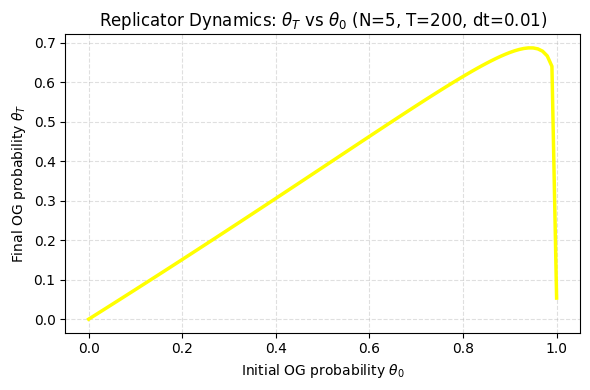

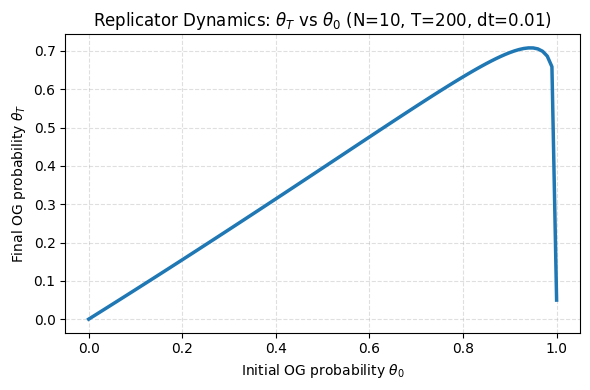

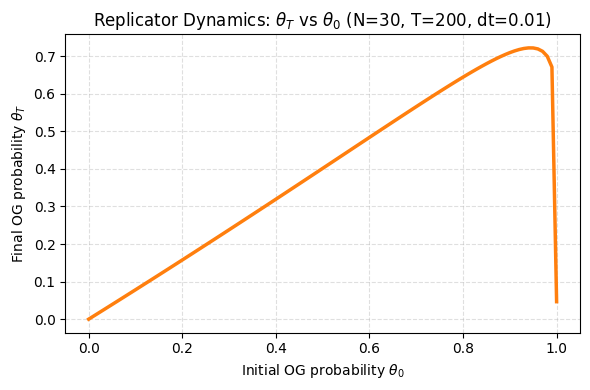

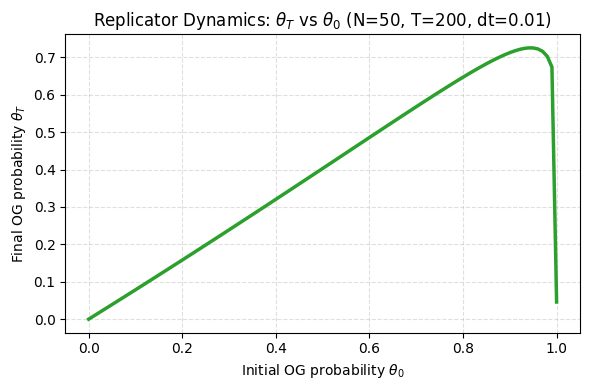

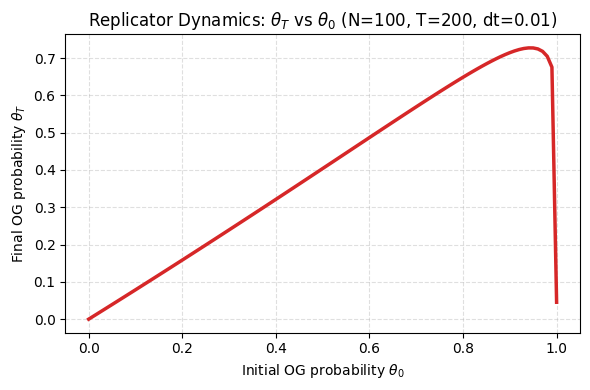

In [ ]:

theta_vals = np.round(np.arange(0.0, 1.0001, 0.01), 2)

N_list   = [5, 10, 30, 50, 100]
colors   = ["yellow", "tab:blue", "tab:orange", "tab:green", "tab:red"]

for N, col in zip(N_list, colors):
    N_A = N

    thetaT_list = []
    for theta0 in theta_vals:
        x_AS, x_OG, y_AA, y_OG = simulate(theta0, T=200.0, dt=0.01)
        thetaT_list.append(x_OG)
    thetaT_list = np.array(thetaT_list)


    plt.figure(figsize=(6, 4))
    plt.plot(theta_vals, thetaT_list, linewidth=2.5, color=col)

    plt.xlabel("Initial OG probability $\\theta_0$")
    plt.ylabel("Final OG probability $\\theta_T$")
    plt.title(f"Replicator Dynamics: $\\theta_T$ vs $\\theta_0$ (N={N}, T=200, dt=0.01)")

    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()


    plt.savefig(f"thetaT_vs_theta0_N{N}.png", dpi=300)
    plt.show()


In [ ]:
import sympy as sp

# ==========================================
# 第一部分：使用 SymPy 自动推导解析解公式
# ==========================================
print("--- 1. SymPy Symbolic Derivation ---")

# 1. 定义符号
x = sp.symbols('x')
epsilon, lam, N, K, alpha, C, B, D, C_J = sp.symbols('epsilon lambda N K alpha C B D C_J')

# 2. 定义总投稿量 V(x)
# V(x) = N * [1 - (1 - alpha)x]
V_x = N * (1 - x * (1 - alpha))

# 3. 定义效用差的分子部分 (即线性部分)
# 这部分等于 0 时，对应内部均衡点 x*
# Linear Part = K*(-D - lambda*B) + (lambda*B - C)*(C_J*V(x) + epsilon)
term_congestion = K * (-D - lam * B)
term_profitability = (lam * B - C)
term_capacity = (C_J * V_x + epsilon)

linear_part = term_congestion + term_profitability * term_capacity

# 4. 求解线性方程 linear_part = 0
sol = sp.solve(linear_part, x)
x_star_symbolic = sol[0]

print(f"推导出的内部根公式 x* = \n{x_star_symbolic}")
print("-" * 30)


# ==========================================
# 第二部分：高效计算函数 (用于 Data Science/Pandas)
# ==========================================
print("\n--- 2. Numerical Calculation Function ---")

def get_internal_root(epsilon, lam, N, K, alpha, C, B, D, C_J):
    """
    计算内部均衡点 x*。
    基于方程: K(-D - lam*B) + (lam*B - C)*(C_J * V(x) + epsilon) = 0
    """

    # 1. 预先计算常数项，防止除以零
    profit_margin = (lam * B - C)

    # 如果投烂文章本身就无利可图 (甚至不需要考虑拥挤)，那么 x* 不存在或无意义
    # 这种情况下通常意味着 x 会坍缩到 1 (Only Good)
    if abs(profit_margin) < 1e-9:
        return None

    # 2. 根据 SymPy 推导结果整理的直接计算公式
    # 公式逻辑：将含 x 的项移到一边，常数项移到另一边
    # Numerator = K(D + lam*B) - (lam*B - C)(C_J*N + epsilon)
    # Denominator = - (lam*B - C) * C_J * N * (1 - alpha)

    # 为了代码清晰，拆分为分子分母：
    # 展开式中常数部分 (不含 x)
    constant_term = K * (-D - lam * B) + profit_margin * (C_J * N + epsilon)

    # 展开式中 x 的系数
    # V(x) 中含 x 项为: -N * (1-alpha) * x
    # 所以 linear_part 中 x 的系数为: profit_margin * C_J * (-N * (1-alpha))
    coeff_x = profit_margin * C_J * (-N * (1 - alpha))

    if abs(coeff_x) < 1e-9:
        return None # 避免除零错误

    # 求解 ax + b = 0  =>  x = -b / a
    x_star = -constant_term / coeff_x

    return x_star

# ==========================================
# 第三部分：测试与验证
# ==========================================

# 定义一组测试参数 (根据经验构造一个可能有解的场景)
params = {
    'epsilon': 0.01,
    'lam': 0.8,
    'N': 1000,
    'K': 100,         # <--- 从 500 修改为 100，制造拥堵
    'alpha': 0.2,
    'C': 10,
    'B': 100,
    'D': 50,
    'C_J': 0.5
}
# 重新运行 get_internal_root...

# 计算
root = get_internal_root(
    params['epsilon'], params['lam'], params['N'], params['K'],
    params['alpha'], params['C'], params['B'], params['D'], params['C_J']
)

print(f"Given Parameters: {params}")
print(f"Calculated Internal Root x*: {root}")

# 验证 x* 是否在 [0, 1] 之间
if root is not None and 0 < root < 1:
    print("Result: 这是一个有效的内部混合均衡点 (3 Roots case: 0, x*, 1)")
else:
    print("Result: 内部根跑到了区间外，此时系统只有边界均衡 (0 或 1)")

--- 1. SymPy Symbolic Derivation ---
推导出的内部根公式 x* = 
(-B*C_J*N*lambda + B*K*lambda - B*epsilon*lambda + C*C_J*N + C*epsilon + D*K)/(C_J*N*(B*alpha*lambda - B*lambda - C*alpha + C))
------------------------------

--- 2. Numerical Calculation Function ---
Given Parameters: {'epsilon': 0.01, 'lam': 0.8, 'N': 1000, 'K': 100, 'alpha': 0.2, 'C': 10, 'B': 100, 'D': 50, 'C_J': 0.5}
Calculated Internal Root x*: 0.7857392857142856
Result: 这是一个有效的内部混合均衡点 (3 Roots case: 0, x*, 1)


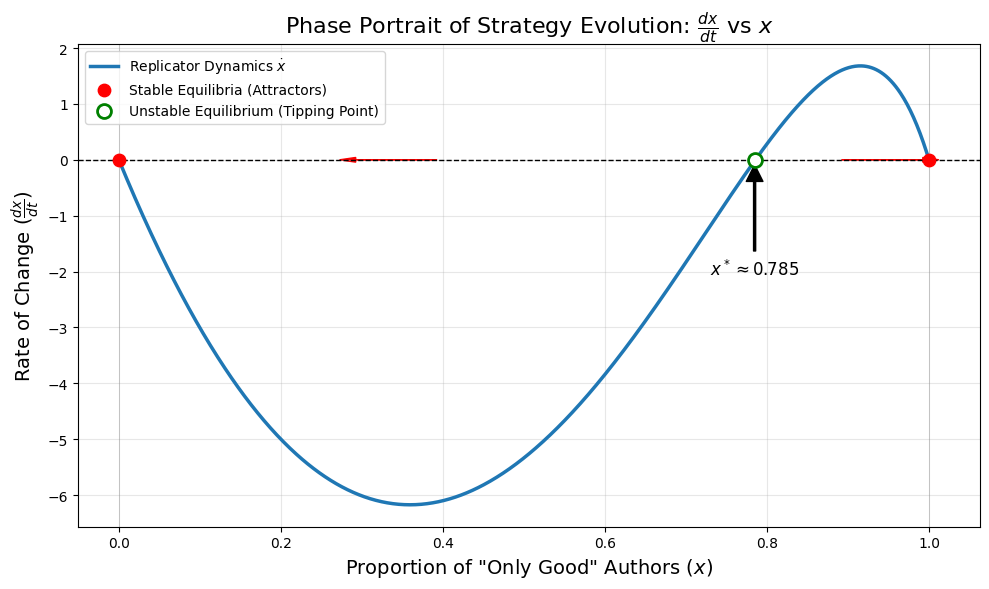

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 参数设定 (Parameters)
# ==========================================
# 使用制造了“拥挤效应”的一组参数 (K=100)
params = {
    'epsilon': 0.01,
    'lam': 0.8,     # 烂文章如果被录用的回报率
    'N': 1000,      # 总作者数
    'K': 100,       # 期刊容量 (比较小，容易拥堵)
    'alpha': 0.2,   # 好文章的产出率
    'C': 10,        # 投稿成本
    'B': 100,       # 录用收益
    'D': 50,        # 拒稿惩罚
    'C_J': 0.5      # 单篇审核成本
}

# ==========================================
# 2. 定义动力学方程 (Dynamics Function)
# ==========================================
def calculate_dxdt(x, p):
    """
    计算 x (Only Good 比例) 的变化率 dx/dt
    """
    # 1. 计算总投稿量 V(x)
    # x 越大，大家越老实，投稿量越少 (只投好文)
    # V(x) = N * [x*alpha + (1-x)*1]
    V_x = p['N'] * (1 - (1 - p['alpha']) * x)

    # 2. 计算审核有效性 Sigma(x)
    # 投稿量 V_x 越大，审核越水
    sigma = p['K'] / (p['C_J'] * V_x + p['epsilon'])

    # 3. 计算投“烂文章”的期望效用 E[U_Bad]
    # E = (被审核概率 * 拒稿亏损) + (漏网概率 * 录用收益)
    # E = sigma * (-D - C) + (1 - sigma) * (lam*B - C)
    # 化简后:
    E_U_Bad = sigma * (-p['D'] - p['lam'] * p['B']) + (p['lam'] * p['B'] - p['C'])

    # 4. 计算效用差 (U_OnlyGood - U_AlwaysSubmit)
    # 这一项决定了 x 是增加还是减少
    # 只有当 E_U_Bad < 0 (投烂文亏本) 时，AlwaysSubmit 才是劣势，x 才会增加
    # Diff = - (1-alpha) * E_U_Bad
    utility_diff = - (1 - p['alpha']) * E_U_Bad

    # 5. 复制动态方程
    dxdt = x * (1 - x) * utility_diff

    return dxdt

# ==========================================
# 3. 计算与绘图 (Plotting)
# ==========================================

# 生成 x 轴数据 (从 0 到 1)
x_values = np.linspace(0, 1, 1000)
y_values = calculate_dxdt(x_values, params)

# 寻找数值解的过零点 (用于在图上标出 x*)
# 找到 y 值符号改变的位置
sign_changes = np.where(np.diff(np.sign(y_values)))[0]
internal_roots = [x_values[i] for i in sign_changes if 0.01 < x_values[i] < 0.99]
x_star = internal_roots[0] if internal_roots else None

# 开始绘图
plt.figure(figsize=(10, 6), dpi=100)

# 绘制主曲线
plt.plot(x_values, y_values, label=r'Replicator Dynamics $\dot{x}$', color='#1f77b4', linewidth=2.5)

# 绘制辅助线 (x轴 和 y轴)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.5, alpha=0.5)
plt.axvline(1, color='gray', linewidth=0.5, alpha=0.5)

# 标记均衡点
# 0 和 1 总是均衡点
plt.scatter([0, 1], [0, 0], color='red', s=80, zorder=5, label='Stable Equilibria (Attractors)')

# 标记内部均衡点 x*
if x_star:
    plt.scatter([x_star], [0], color='white', edgecolor='green', s=100, linewidth=2, zorder=5, label='Unstable Equilibrium (Tipping Point)')
    plt.annotate(f'$x^* \\approx {x_star:.3f}$',
                 xy=(x_star, 0), xytext=(x_star, min(y_values)/3),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                 ha='center', fontsize=12, fontweight='bold')

# 添加箭头指示流动方向 (Phase Portrait arrows)
# 在 x* 左侧，dx/dt < 0，向左流
# 在 x* 右侧，dx/dt > 0，向右流
y_mid = max(y_values) * 0.1
if x_star:
    plt.arrow(x_star/2, 0, -0.1, 0, head_width=y_mid*0.5, head_length=0.02, fc='red', ec='red')
    plt.arrow((1+x_star)/2, 0, 0.1, 0, head_width=y_mid*0.5, head_length=0.02, fc='red', ec='red')

# 图表装饰
plt.title(r'Phase Portrait of Strategy Evolution: $\frac{dx}{dt}$ vs $x$', fontsize=16)
plt.xlabel(r'Proportion of "Only Good" Authors ($x$)', fontsize=14)
plt.ylabel(r'Rate of Change ($\frac{dx}{dt}$)', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Starting simulation loops...
Simulation complete.


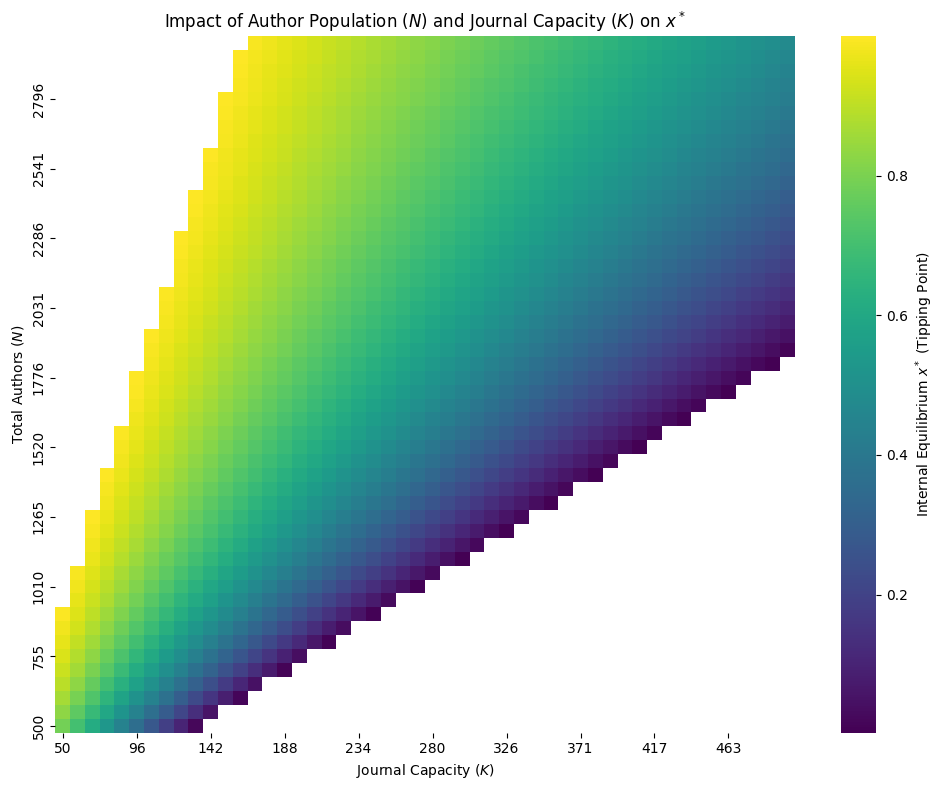

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ==========================================
# 1. Define the Calculation Function
# ==========================================
def get_internal_root(N, K, epsilon, lam, alpha, C, B, D, C_J):
    """
    Calculates the internal equilibrium x* analytically.
    Returns x* if it exists and is within (0, 1), otherwise returns NaN.

    Parameters:
    N : Total number of authors
    K : Journal capacity
    ... (other parameters as defined in the model)
    """
    # Pre-calculate profit margin for bad papers
    profit_margin = (lam * B - C)

    # Avoid division by zero if profit margin is 0
    if abs(profit_margin) < 1e-9:
        return np.nan

    # The equation for x* is derived from setting the numerator of the utility difference to 0.
    # We derived the linear form: A + B * x = 0  =>  x = -A / B

    # Constant term in the linear equation (independent of x)
    constant_term = K * (-D - lam * B) + profit_margin * (C_J * N + epsilon)

    # Coefficient of x in the linear equation
    # Derived from: profit_margin * C_J * V(x)'s x-term
    # V(x) has a term: -N * (1 - alpha) * x
    coeff_x = profit_margin * C_J * (-N * (1 - alpha))

    if abs(coeff_x) < 1e-9:
        return np.nan

    x_star = -constant_term / coeff_x

    # Check if the root is physically meaningful (strictly between 0 and 1)
    # If x* is outside (0, 1), the system has no internal equilibrium (only boundaries 0 and 1).
    if 0 < x_star < 1:
        return x_star
    else:
        return np.nan

# ==========================================
# 2. Set Up Parameters and Loops
# ==========================================

# Fixed Parameters (Constants)
epsilon = 0.01
lam = 0.8       # Return rate for successful bad paper
alpha = 0.2     # Proportion of "Good" papers naturally
C = 10          # Submission cost
B = 100         # Benefit of acceptance
D = 50          # Damage from rejection
C_J = 0.5       # Cost to review one paper

# Define Ranges for the Loops
# We want to sweep N (Author Population) and K (Journal Capacity)
N_values = np.linspace(500, 3000, 50)  # N from 500 to 3000
K_values = np.linspace(50, 500, 50)    # K from 50 to 500

# Matrix to store results (rows=N, cols=K)
results_matrix = np.zeros((len(N_values), len(K_values)))

# Nested Loops to sweep parameters
print("Starting simulation loops...")
for i, n_val in enumerate(N_values):
    for j, k_val in enumerate(K_values):

        # Calculate x* for this specific pair of (N, K)
        x_star = get_internal_root(
            N=n_val, K=k_val,
            epsilon=epsilon, lam=lam, alpha=alpha,
            C=C, B=B, D=D, C_J=C_J
        )

        results_matrix[i, j] = x_star
print("Simulation complete.")

# ==========================================
# 3. Visualization (Heatmap)
# ==========================================
plt.figure(figsize=(10, 8))

# Convert to DataFrame for easier labelling with Seaborn
# Index: N values, Columns: K values
df_results = pd.DataFrame(
    results_matrix,
    index=np.round(N_values).astype(int),
    columns=np.round(K_values).astype(int)
)

# Plot Heatmap
# Mask: We hide cells where x* is NaN (i.e., no internal equilibrium exists)
sns.heatmap(
    df_results,
    cmap="viridis",
    mask=df_results.isnull(),
    cbar_kws={'label': r'Internal Equilibrium $x^*$ (Tipping Point)'},
    xticklabels=5,
    yticklabels=5
)

plt.title(r'Impact of Author Population ($N$) and Journal Capacity ($K$) on $x^*$')
plt.xlabel(r'Journal Capacity ($K$)')
plt.ylabel(r'Total Authors ($N$)')

# Adjust y-axis direction (Seaborn puts index 0 at top by default, we want standard Cartesian)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

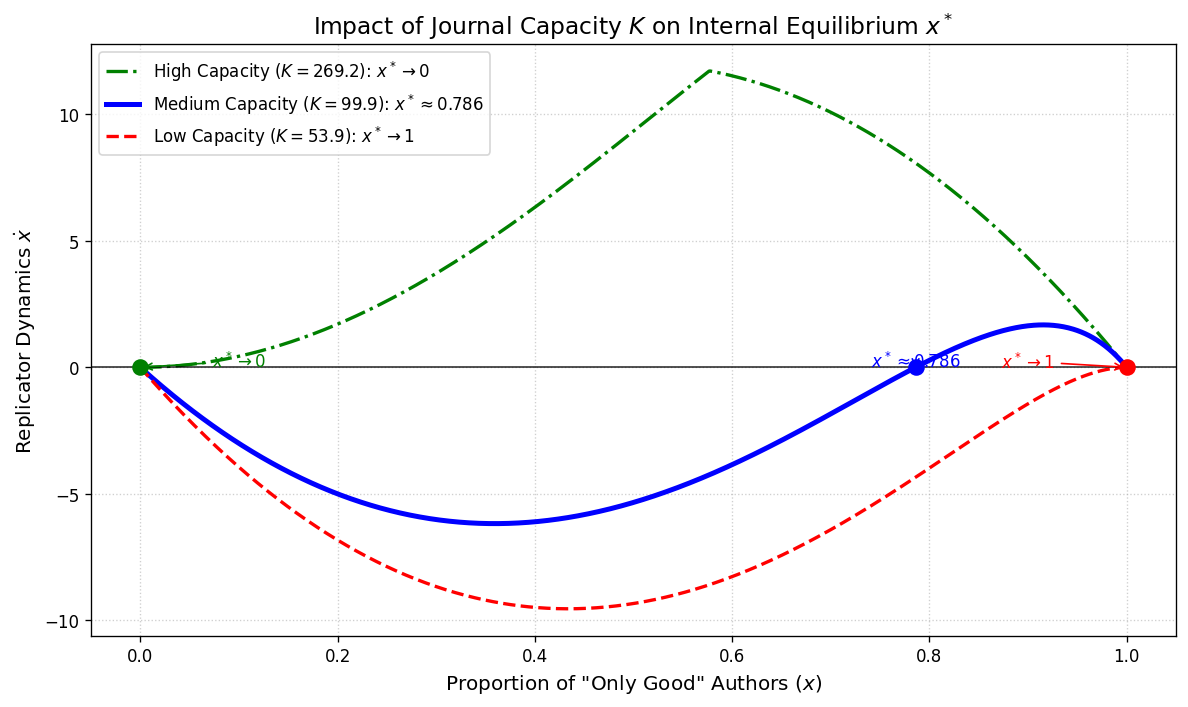

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings
# ==========================================
params = {
    'epsilon': 0.01,
    'lam': 0.8,     # Return rate if bad paper accepted
    'N': 1000,      # Total authors
    'alpha': 0.2,   # Probability of producing good paper
    'C': 10,        # Submission cost
    'B': 100,       # Benefit of acceptance
    'D': 50,        # Penalty for rejection (bad paper)
    'C_J': 0.5      # Cost of review per paper
}

# ==========================================
# 2. Helper Functions
# ==========================================
def calculate_required_K(target_x_star, p):
    """
    Calculate K required to set the internal equilibrium at target_x_star.
    """
    V_star = p['N'] * (1 - (1 - p['alpha']) * target_x_star)
    numerator = p['lam'] * p['B'] - p['C']
    denominator = p['D'] + p['lam'] * p['B']
    required_sigma = numerator / denominator
    K_val = required_sigma * (p['C_J'] * V_star + p['epsilon'])
    return K_val

def calculate_dxdt(x, K, p):
    """
    Calculate dx/dt for a given x and K.
    """
    V_x = p['N'] * (1 - (1 - p['alpha']) * x)
    sigma = K / (p['C_J'] * V_x + p['epsilon'])
    # Cap sigma at 1.0
    sigma = np.clip(sigma, 0, 1)

    # Expected Utility of Bad Paper
    E_U_Bad = sigma * (-p['D'] - p['lam'] * p['B']) + (p['lam'] * p['B'] - p['C'])

    # Replicator equation: dx/dt ~ -x(1-x) * E[U_Bad]
    dxdt = - x * (1 - x) * (1 - p['alpha']) * E_U_Bad
    return dxdt

# ==========================================
# 3. Calculate K values for three scenarios
# ==========================================
K_for_0 = calculate_required_K(0.0, params)     # x* -> 0
K_for_1 = calculate_required_K(1.0, params)     # x* -> 1
K_for_mid = calculate_required_K(0.786, params) # x* = 0.786

# ==========================================
# 4. Plotting
# ==========================================
x_values = np.linspace(0, 1, 1000)

# Calculate curves
y_0 = calculate_dxdt(x_values, K_for_0, params)
y_mid = calculate_dxdt(x_values, K_for_mid, params)
y_1 = calculate_dxdt(x_values, K_for_1, params)

plt.figure(figsize=(10, 6), dpi=120)

# Plot curves
# High Capacity (Green) -> Global Honesty
plt.plot(x_values, y_0, color='green', linewidth=2, linestyle='-.',
         label=f'High Capacity ($K={K_for_0:.1f}$): $x^* \\to 0$')

# Medium Capacity (Blue) -> Bistability
plt.plot(x_values, y_mid, color='blue', linewidth=3,
         label=f'Medium Capacity ($K={K_for_mid:.1f}$): $x^* \\approx 0.786$')

# Low Capacity (Red) -> Global Corruption
plt.plot(x_values, y_1, color='red', linewidth=2, linestyle='--',
         label=f'Low Capacity ($K={K_for_1:.1f}$): $x^* \\to 1$')

# Zero line
plt.axhline(0, color='black', linewidth=1, alpha=0.8)

# Annotations
# Point for x*=0.786
plt.scatter([0.786], [0], color='blue', s=80, zorder=5)
plt.annotate(r'$x^* \approx 0.786$', xy=(0.786, 0), xytext=(0.786, 0.005),
             ha='center', color='blue', fontsize=10, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='blue'))

# Point for x*=0
plt.scatter([0], [0], color='green', s=80, zorder=5)
plt.annotate(r'$x^* \to 0$', xy=(0, 0), xytext=(0.1, 0.008),
             ha='center', color='green', fontsize=10, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='green'))

# Point for x*=1
plt.scatter([1], [0], color='red', s=80, zorder=5)
plt.annotate(r'$x^* \to 1$', xy=(1, 0), xytext=(0.9, -0.008),
             ha='center', color='red', fontsize=10, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='red'))

# Styling
plt.title(r'Impact of Journal Capacity $K$ on Internal Equilibrium $x^*$', fontsize=14)
plt.xlabel('Proportion of "Only Good" Authors ($x$)', fontsize=12)
plt.ylabel(r'Replicator Dynamics $\dot{x}$', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='best')
plt.tight_layout()

plt.show()

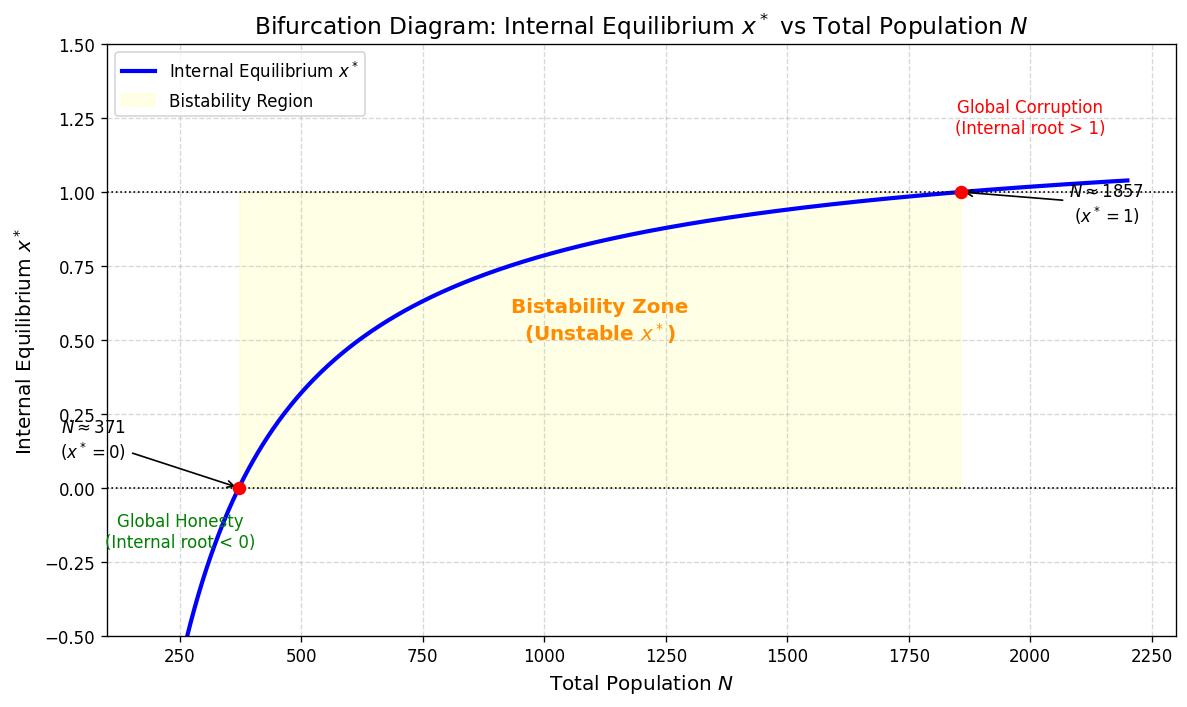

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings
# ==========================================
params = {
    'epsilon': 0.01,
    'lam': 0.8,
    'K': 100,       # Fixed Capacity
    'alpha': 0.2,
    'C': 10,
    'B': 100,
    'D': 50,
    'C_J': 0.5
}

# ==========================================
# 2. Mathematical Derivation
# ==========================================
# The internal equilibrium x* is determined by the condition E[U_Bad] = 0.
# This leads to a required screening probability sigma*:
# sigma* = (lam * B - C) / (D + lam * B)
#
# The physical relation between Capacity K, Population N, and x* is:
# sigma* = K / (C_J * V(x*) + epsilon)
#
# Where volume V(x*) = N * [1 - (1 - alpha) * x*]
#
# Solving for x* as a function of N:
# x*(N) = (1 / (1 - alpha)) * (1 - (K / sigma* - epsilon) / (C_J * N))

def calculate_x_star(N, p):
    # 1. Calculate target sigma
    numerator = p['lam'] * p['B'] - p['C']
    denominator = p['D'] + p['lam'] * p['B']
    sigma_star = numerator / denominator

    # 2. Calculate the term A = (K/sigma* - epsilon) / C_J
    # This represents the critical volume threshold
    A = (p['K'] / sigma_star - p['epsilon']) / p['C_J']

    # 3. Calculate x*
    # Note: This is the algebraic root. It might be < 0 or > 1.
    # We will plot it even outside bounds to show the trend.
    term = A / N
    x_val = (1 / (1 - p['alpha'])) * (1 - term)

    return x_val

# ==========================================
# 3. Generate Data
# ==========================================
# Range of N to cover all three regimes (Honesty, Bistability, Corruption)
N_values = np.linspace(200, 2200, 1000)
x_star_values = calculate_x_star(N_values, params)

# Identify critical N values for x*=0 and x*=1
# x*=0  =>  1 - A/N = 0  => N = A
# x*=1  =>  1 - A/N = 1-alpha => A/N = alpha => N = A/alpha
numerator = params['lam'] * params['B'] - params['C']
denominator = params['D'] + params['lam'] * params['B']
sigma_star = numerator / denominator
A = (params['K'] / sigma_star - params['epsilon']) / params['C_J']

N_crit_0 = A              # Boundary for Global Honesty
N_crit_1 = A / params['alpha']   # Boundary for Global Corruption

# ==========================================
# 4. Plotting
# ==========================================
plt.figure(figsize=(10, 6), dpi=120)

# Plot the main curve
plt.plot(N_values, x_star_values, label=r'Internal Equilibrium $x^*$', color='blue', linewidth=2.5)

# Highlight the physically meaningful region (0 <= x* <= 1)
# This is the "Bistable Region"
valid_mask = (x_star_values >= 0) & (x_star_values <= 1)
plt.fill_between(N_values, 0, 1, where=valid_mask, color='yellow', alpha=0.1, label='Bistability Region')

# Add horizontal lines for x=0 and x=1
plt.axhline(0, color='black', linestyle=':', linewidth=1)
plt.axhline(1, color='black', linestyle=':', linewidth=1)

# Mark critical N values
plt.scatter([N_crit_0, N_crit_1], [0, 1], color='red', s=50, zorder=5)

# Annotation for N_crit_0 (Transition to Bistability from Honesty)
plt.annotate(f'$N \\approx {int(N_crit_0)}$\n($x^*=0$)',
             xy=(N_crit_0, 0), xytext=(N_crit_0 - 300, 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             ha='center', fontsize=10)

# Annotation for N_crit_1 (Transition to Corruption)
plt.annotate(f'$N \\approx {int(N_crit_1)}$\n($x^*=1$)',
             xy=(N_crit_1, 1), xytext=(N_crit_1 + 300, 0.9),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             ha='center', fontsize=10)

# Add regime labels
# Regime 1: Low N (x* < 0) -> Global Honesty
plt.text(250, -0.2, "Global Honesty\n(Internal root < 0)", fontsize=10, color='green', ha='center')

# Regime 2: Bistability
plt.text((N_crit_0 + N_crit_1)/2, 0.5, "Bistability Zone\n(Unstable $x^*$)", fontsize=12, color='darkorange', ha='center', fontweight='bold')

# Regime 3: High N (x* > 1) -> Global Corruption
plt.text(2000, 1.2, "Global Corruption\n(Internal root > 1)", fontsize=10, color='red', ha='center')

# Styling
plt.title(r'Bifurcation Diagram: Internal Equilibrium $x^*$ vs Total Population $N$', fontsize=14)
plt.xlabel(r'Total Population $N$', fontsize=12)
plt.ylabel(r'Internal Equilibrium $x^*$', fontsize=12)
plt.ylim(-0.5, 1.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left')
plt.tight_layout()

# Save
plt.savefig('N_bifurcation.pdf')
plt.show()

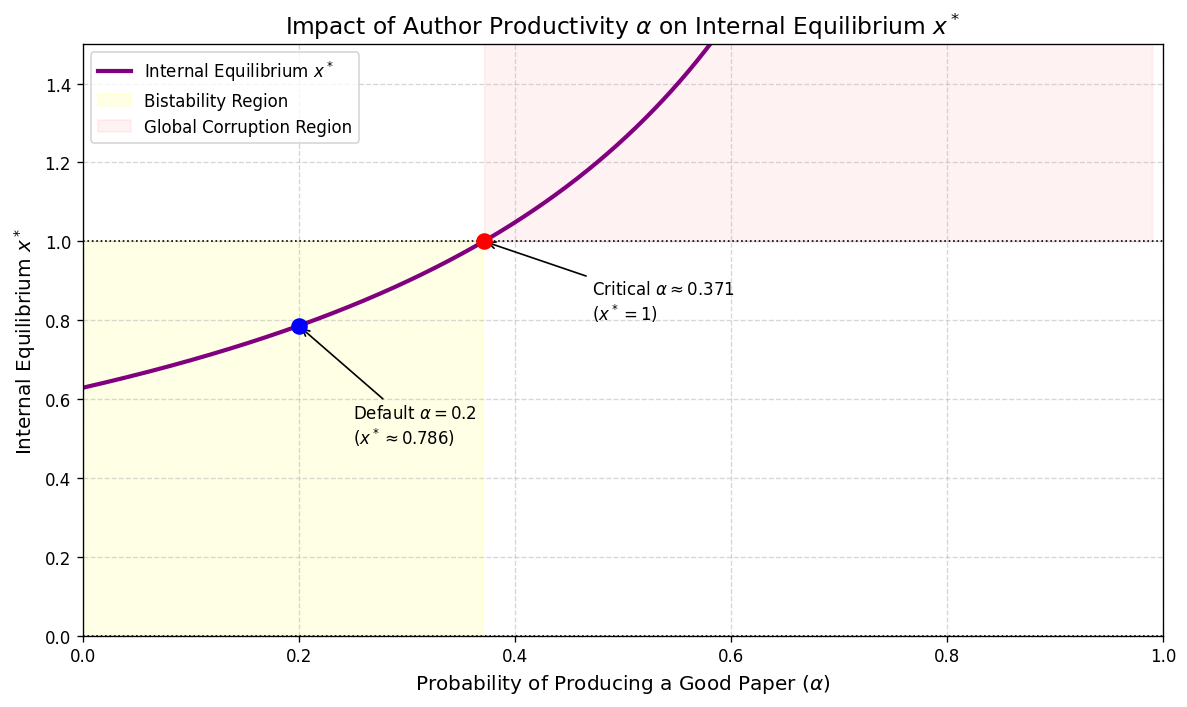

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings (Default N=1000, K=100)
# ==========================================
params = {
    'epsilon': 0.01,
    'lam': 0.8,
    'N': 1000,      # Restored to Default
    'K': 100,       # Default
    # 'alpha': Variable
    'C': 10,
    'B': 100,
    'D': 50,
    'C_J': 0.5
}

# ==========================================
# 2. Mathematical Derivation
# ==========================================
# We derived x* as a function of alpha:
# x*(alpha) = (1 - A) / (1 - alpha)
# Where A is the ratio of (Target Volume for sigma*) to N.
# A = (1 / (N * C_J)) * (K/sigma* - epsilon)

def calculate_x_star_alpha(alpha_values, p):
    # 1. Calculate target sigma (Independent of alpha)
    numerator = p['lam'] * p['B'] - p['C']
    denominator = p['D'] + p['lam'] * p['B']
    sigma_star = numerator / denominator

    # 2. Calculate the term A (Volume threshold ratio)
    # Target Volume V* = (K/sigma* - epsilon) / C_J
    # A = V* / N
    V_star = (p['K'] / sigma_star - p['epsilon']) / p['C_J']
    A = V_star / p['N']

    # 3. Calculate x*
    # Formula: x* = (1 - A) / (1 - alpha)
    # Note: If alpha -> 1, this diverges.
    x_stars = (1 - A) / (1 - alpha_values)

    return x_stars, A

# ==========================================
# 3. Generate Data
# ==========================================
alpha_range = np.linspace(0, 0.99, 1000) # Avoid 1.0 to prevent division by zero
x_star_values, A_val = calculate_x_star_alpha(alpha_range, params)

# Calculate critical alpha where x* = 1
# 1 = (1 - A) / (1 - alpha) => 1 - alpha = 1 - A => alpha = A
alpha_crit = A_val

# ==========================================
# 4. Plotting
# ==========================================
plt.figure(figsize=(10, 6), dpi=120)

# Plot the curve
plt.plot(alpha_range, x_star_values, label=r'Internal Equilibrium $x^*$', color='purple', linewidth=2.5)

# Highlight Regions
# Region 1: Bistability (0 <= x* <= 1) -> Occurs when alpha < alpha_crit
plt.fill_between(alpha_range, 0, 1,
                 where=(alpha_range <= alpha_crit),
                 color='yellow', alpha=0.1, label='Bistability Region')

# Region 2: Global Corruption (x* > 1) -> Occurs when alpha > alpha_crit
plt.fill_between(alpha_range, 1, 2,
                 where=(alpha_range > alpha_crit),
                 color='red', alpha=0.05, label='Global Corruption Region')

# Critical Point Annotation
if 0 <= alpha_crit <= 1:
    plt.scatter([alpha_crit], [1], color='red', s=80, zorder=5)
    plt.annotate(f'Critical $\\alpha \\approx {alpha_crit:.3f}$\n($x^*=1$)',
                 xy=(alpha_crit, 1), xytext=(alpha_crit + 0.1, 0.8),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 ha='left', fontsize=10)

# Default Point Annotation (alpha=0.2)
x_default = (1 - A_val) / (1 - 0.2)
plt.scatter([0.2], [x_default], color='blue', s=80, zorder=5)
plt.annotate(f'Default $\\alpha=0.2$\n($x^* \\approx {x_default:.3f}$)',
             xy=(0.2, x_default), xytext=(0.25, x_default - 0.3),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             ha='left', fontsize=10)

# Limit Y-axis to relevant range
plt.ylim(0, 1.5)
plt.xlim(0, 1.0)

# Formatting
plt.axhline(1, color='black', linestyle=':', linewidth=1)
plt.axhline(0, color='black', linestyle=':', linewidth=1)
plt.title(r'Impact of Author Productivity $\alpha$ on Internal Equilibrium $x^*$', fontsize=14)
plt.xlabel(r'Probability of Producing a Good Paper ($\alpha$)', fontsize=12)
plt.ylabel(r'Internal Equilibrium $x^*$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left')

# Save
plt.tight_layout()
plt.savefig('alpha_impact_analysis.pdf')
plt.show()

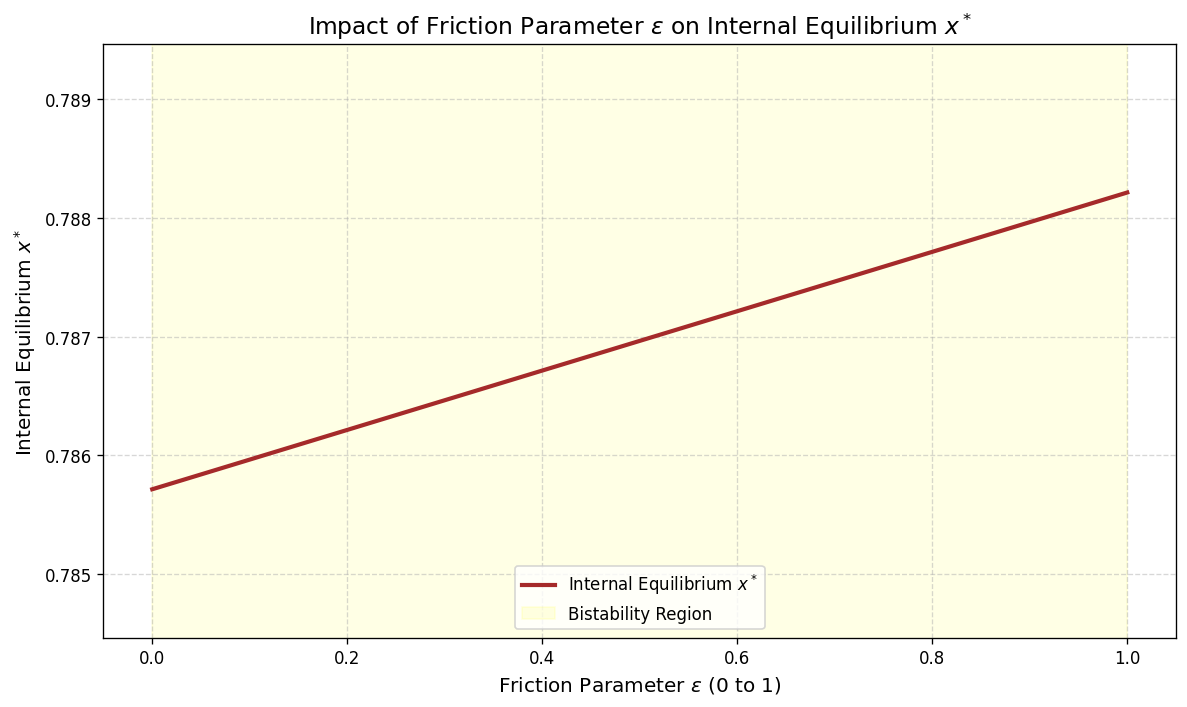

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings (Restored to Defaults)
# ==========================================
params = {
    # 'epsilon': Variable (0 to 1),
    'lam': 0.8,     # Return rate for bad papers
    'N': 1000,      # Default N
    'K': 100,       # Default K
    'alpha': 0.2,   # Probability of producing a good paper
    'C': 10,        # Cost of submission
    'B': 100,       # Benefit of acceptance
    'D': 50,        # Penalty for rejection
    'C_J': 0.5      # Cost of review per paper
}

# ==========================================
# 2. Mathematical Derivation
# ==========================================
# Formula for x* with variable epsilon:
# x*(epsilon) = (1 / (1 - alpha)) * [ 1 - (K/sigma* - epsilon) / (N * C_J) ]
#
# Where sigma* is the critical screening probability:
# sigma* = (lam * B - C) / (D + lam * B)

def calculate_x_star_epsilon(epsilon_values, p):
    # 1. Calculate target sigma (Independent of epsilon)
    numerator = p['lam'] * p['B'] - p['C']
    denominator = p['D'] + p['lam'] * p['B']
    sigma_star = numerator / denominator

    # 2. Calculate x* for each epsilon
    # Term = (K/sigma* - epsilon) / (N * C_J)
    # x* = (1 - Term) / (1 - alpha)

    K_over_sigma = p['K'] / sigma_star
    NCJ = p['N'] * p['C_J']

    x_stars = []
    for eps in epsilon_values:
        term = (K_over_sigma - eps) / NCJ
        val = (1 - term) / (1 - p['alpha'])
        x_stars.append(val)

    return np.array(x_stars)

# ==========================================
# 3. Generate Data
# ==========================================
epsilon_range = np.linspace(0, 1, 1000)
x_star_values = calculate_x_star_epsilon(epsilon_range, params)

# ==========================================
# 4. Plotting
# ==========================================
plt.figure(figsize=(10, 6), dpi=120)

# Plot the curve
plt.plot(epsilon_range, x_star_values, label=r'Internal Equilibrium $x^*$', color='brown', linewidth=2.5)

# Add simplified bounds for context (0 and 1)
plt.axhline(0, color='black', linestyle=':', linewidth=1)
plt.axhline(1, color='black', linestyle=':', linewidth=1)
plt.fill_between(epsilon_range, 0, 1, color='yellow', alpha=0.1, label='Bistability Region')

# Styling
plt.title(r'Impact of Friction Parameter $\epsilon$ on Internal Equilibrium $x^*$', fontsize=14)
plt.xlabel(r'Friction Parameter $\epsilon$ (0 to 1)', fontsize=12)
plt.ylabel(r'Internal Equilibrium $x^*$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')

# Adjust y-limits to show the (likely small) variation clearly
# We add a small margin around the min/max values
y_min, y_max = min(x_star_values), max(x_star_values)
margin = (y_max - y_min) * 0.5 if y_max != y_min else 0.1
plt.ylim(y_min - margin, y_max + margin)

# Save
plt.tight_layout()
plt.savefig('epsilon_x.pdf')
plt.show()

<>:95: SyntaxWarning: invalid escape sequence '\l'
<>:101: SyntaxWarning: invalid escape sequence '\l'
<>:95: SyntaxWarning: invalid escape sequence '\l'
<>:101: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3444346478.py:95: SyntaxWarning: invalid escape sequence '\l'
  plt.annotate(f'$\lambda \\approx {lam_crit_0:.2f}$\n($x^*=0$)',
/tmp/ipython-input-3444346478.py:101: SyntaxWarning: invalid escape sequence '\l'
  plt.annotate(f'$\lambda \\approx {lam_crit_1:.2f}$\n($x^*=1$)',


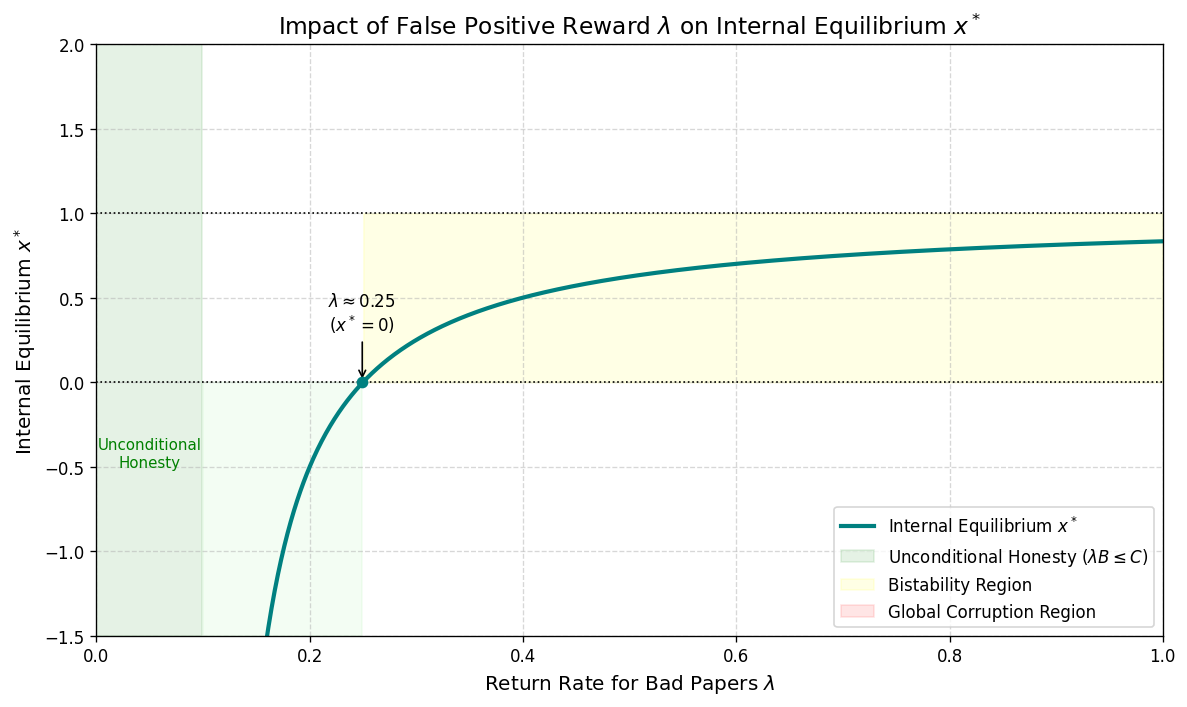

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings (Restored to Defaults)
# ==========================================
params = {
    'epsilon': 0.01,
    'N': 1000,      # Default N
    'K': 100,       # Default K
    'alpha': 0.2,   # Probability of producing a good paper
    'C': 10,        # Cost of submission
    'B': 100,       # Benefit of acceptance
    'D': 50,        # Penalty for rejection
    'C_J': 0.5      # Cost of review per paper
}

# ==========================================
# 2. Mathematical Derivation
# ==========================================
def calculate_x_star_lambda(lam_values, p):
    x_stars = []

    for lam in lam_values:
        # Calculate profitability of bad paper
        profit = lam * p['B'] - p['C']

        if profit <= 0:
            # Unconditional Honesty
            # Mathematically x* -> -infinity, using clamp for plot
            x_stars.append(-2.0)
        else:
            numerator = profit
            denominator = p['D'] + lam * p['B']
            sigma_star = numerator / denominator

            # Critical Volume
            V_crit = (p['K'] / sigma_star - p['epsilon']) / p['C_J']

            # x*
            val = (1 - V_crit / p['N']) / (1 - p['alpha'])
            x_stars.append(val)

    return np.array(x_stars)

# ==========================================
# 3. Generate Data
# ==========================================
lam_range = np.linspace(0, 1, 1000)
x_star_values = calculate_x_star_lambda(lam_range, params)

lam_profit = 0.1 # Threshold where lambda*B = C
indices_0 = np.where(np.diff(np.sign(x_star_values - 0)))[0]
lam_crit_0 = lam_range[indices_0[0]] if indices_0.size > 0 else None

indices_1 = np.where(np.diff(np.sign(x_star_values - 1)))[0]
lam_crit_1 = lam_range[indices_1[0]] if indices_1.size > 0 else None

# ==========================================
# 4. Plotting
# ==========================================
plt.figure(figsize=(10, 6), dpi=120)

plt.plot(lam_range, x_star_values, label=r'Internal Equilibrium $x^*$', color='teal', linewidth=2.5)

plt.ylim(-1.5, 2.0)
plt.xlim(0, 1.0)

# Regions
# 1. Unconditional Honesty
plt.fill_between(lam_range, -1.5, 2.0, where=(lam_range <= lam_profit),
                 color='green', alpha=0.1, label=r'Unconditional Honesty ($\lambda B \leq C$)')

# 2. Capacity-enforced Honesty
if lam_crit_0:
    plt.fill_between(lam_range, -1.5, 0, where=(lam_range > lam_profit) & (lam_range <= lam_crit_0),
                     color='lightgreen', alpha=0.1)

# 3. Bistability
plt.fill_between(lam_range, 0, 1, where=(x_star_values >= 0) & (x_star_values <= 1),
                 color='yellow', alpha=0.1, label='Bistability Region')

# 4. Global Corruption
plt.fill_between(lam_range, 1, 2.0, where=(x_star_values > 1),
                 color='red', alpha=0.1, label='Global Corruption Region')

plt.axhline(0, color='black', linestyle=':', linewidth=1)
plt.axhline(1, color='black', linestyle=':', linewidth=1)

# Annotations
plt.text(0.05, -0.5, "Unconditional\nHonesty", fontsize=9, color='green', ha='center')

if lam_crit_0:
    plt.scatter([lam_crit_0], [0], color='teal', zorder=5)
    plt.annotate(f'$\lambda \\approx {lam_crit_0:.2f}$\n($x^*=0$)',
                 xy=(lam_crit_0, 0), xytext=(lam_crit_0, 0.3),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

if lam_crit_1:
    plt.scatter([lam_crit_1], [1], color='red', zorder=5)
    plt.annotate(f'$\lambda \\approx {lam_crit_1:.2f}$\n($x^*=1$)',
                 xy=(lam_crit_1, 1), xytext=(lam_crit_1 - 0.15, 1.2),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

plt.title(r'Impact of False Positive Reward $\lambda$ on Internal Equilibrium $x^*$', fontsize=14)
plt.xlabel(r'Return Rate for Bad Papers $\lambda$', fontsize=12)
plt.ylabel(r'Internal Equilibrium $x^*$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('lambda_x.pdf')
plt.show()

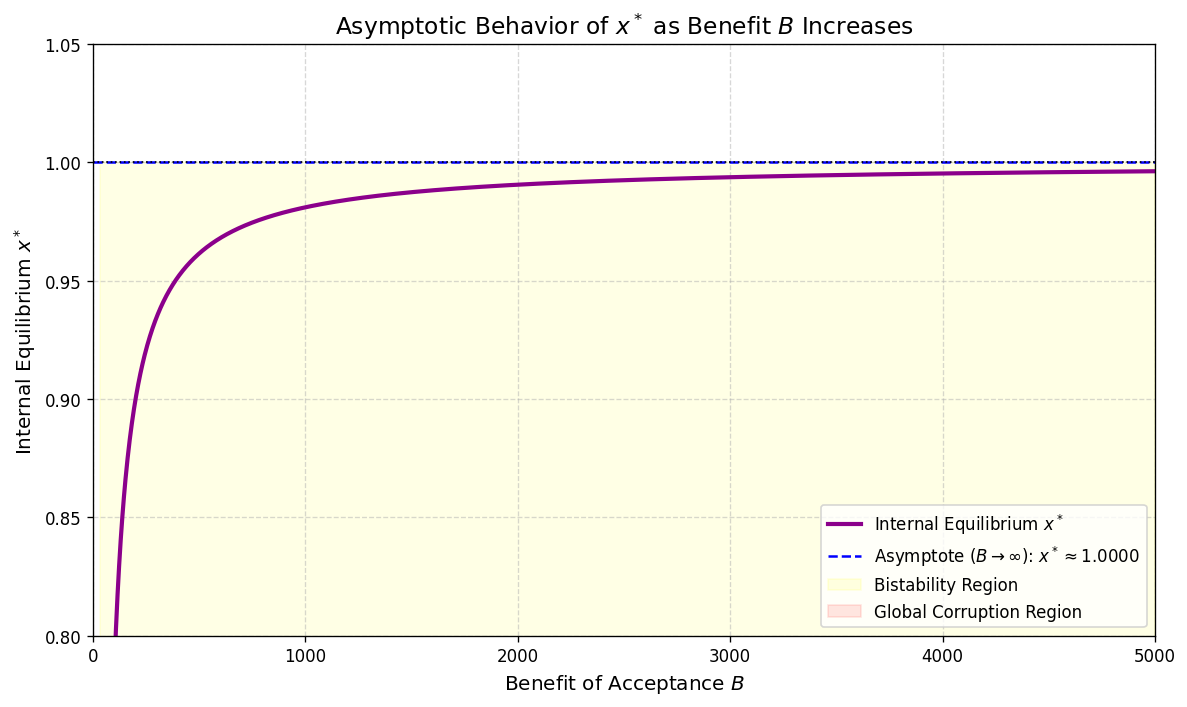

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings (Restored to Defaults)
# ==========================================
params = {
    'epsilon': 0.01,
    'lam': 0.8,
    'N': 1000,      # Default N
    'K': 100,       # Default K
    'alpha': 0.2,   # Probability of producing a good paper
    'C': 10,        # Cost of submission
    # 'B': Variable (High Range)
    'D': 50,        # Penalty for rejection
    'C_J': 0.5      # Cost of review per paper
}

# ==========================================
# 2. Mathematical Derivation
# ==========================================
def calculate_x_star_B(B_values, p):
    x_stars = []

    for B in B_values:
        # Profitability
        profit = p['lam'] * B - p['C']

        if profit <= 0:
            x_stars.append(-2.0) # Unconditional Honesty
        else:
            numerator = profit
            denominator = p['D'] + p['lam'] * B
            sigma_star = numerator / denominator

            # Critical Volume
            V_crit = (p['K'] / sigma_star - p['epsilon']) / p['C_J']

            # x*
            val = (1 - V_crit / p['N']) / (1 - p['alpha'])
            x_stars.append(val)

    return np.array(x_stars)

# ==========================================
# 3. Generate Data (Extended Range)
# ==========================================
# Extend B to 5000 to observe convergence
B_range = np.linspace(0, 5000, 2000)
x_star_values = calculate_x_star_B(B_range, params)

# Calculate Asymptote (Limit as B -> infinity)
# sigma* -> 1
# V_crit -> (K - epsilon) / C_J
# x* -> (1 - V_crit/N) / (1 - alpha)
V_crit_inf = (params['K'] - params['epsilon']) / params['C_J']
x_star_inf = (1 - V_crit_inf / params['N']) / (1 - params['alpha'])

# ==========================================
# 4. Plotting
# ==========================================
plt.figure(figsize=(10, 6), dpi=120)

plt.plot(B_range, x_star_values, label=r'Internal Equilibrium $x^*$', color='darkmagenta', linewidth=2.5)
plt.axhline(x_star_inf, color='blue', linestyle='--', linewidth=1.5, label=f'Asymptote ($B \\to \\infty$): $x^* \\approx {x_star_inf:.4f}$')

# Set Limits
plt.ylim(0.8, 1.05) # Focus on the transition near 1
plt.xlim(0, 5000)

# Highlight Regions
plt.fill_between(B_range, 0, 1, where=(x_star_values >= 0) & (x_star_values <= 1),
                 color='yellow', alpha=0.1, label='Bistability Region')

plt.fill_between(B_range, 1, 2.0, where=(x_star_values > 1),
                 color='red', alpha=0.1, label='Global Corruption Region')

plt.axhline(1, color='black', linestyle=':', linewidth=1)

# Annotations
# Find where it crosses 1
indices_1 = np.where(np.diff(np.sign(x_star_values - 1)))[0]
if indices_1.size > 0:
    B_crit = B_range[indices_1[0]]
    plt.scatter([B_crit], [1], color='red', zorder=5)
    plt.annotate(f'Critical $B \\approx {B_crit:.0f}$',
                 xy=(B_crit, 1), xytext=(B_crit + 500, 0.95),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

plt.title(r'Asymptotic Behavior of $x^*$ as Benefit $B$ Increases', fontsize=14)
plt.xlabel(r'Benefit of Acceptance $B$', fontsize=12)
plt.ylabel(r'Internal Equilibrium $x^*$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('B_x_extended.pdf')
plt.show()

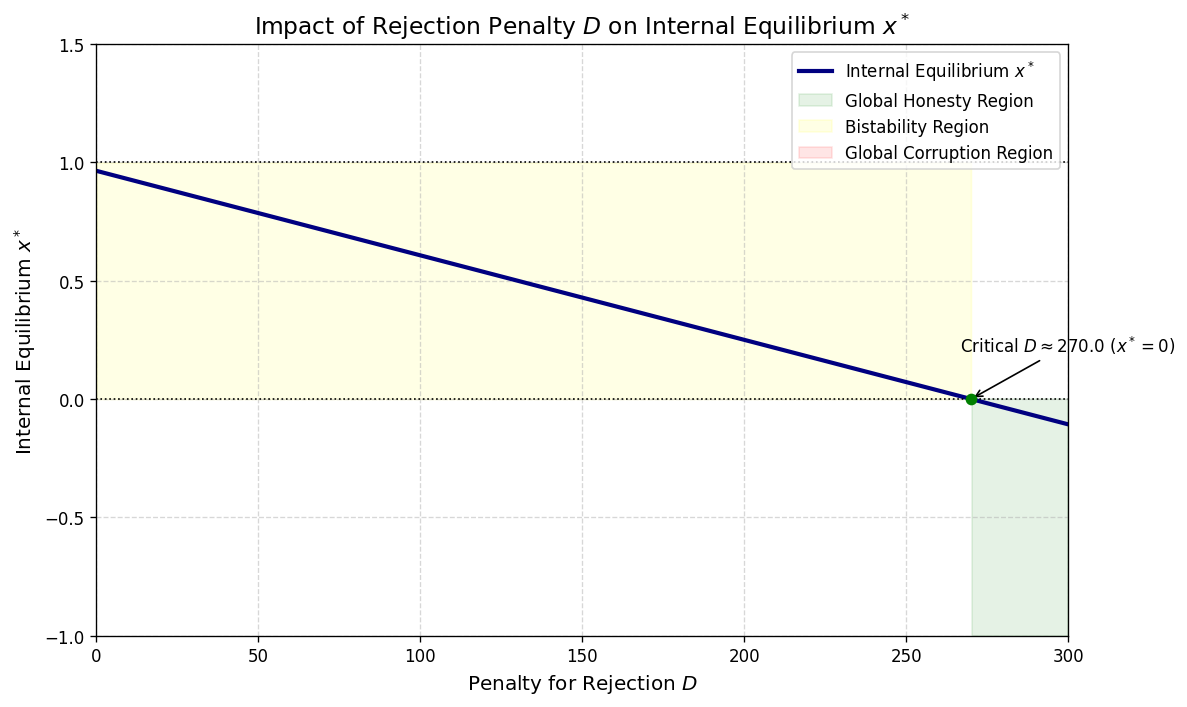

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings (Restored to Defaults)
# ==========================================
params = {
    'epsilon': 0.01,
    'lam': 0.8,
    'N': 1000,      # Default N
    'K': 100,       # Default K
    'alpha': 0.2,   # Probability of producing a good paper
    'C': 10,        # Cost of submission
    'B': 100,       # Benefit of acceptance
    # 'D': Variable,
    'C_J': 0.5      # Cost of review per paper
}

# ==========================================
# 2. Mathematical Derivation
# ==========================================
def calculate_x_star_D(D_values, p):
    x_stars = []

    for D in D_values:
        # Profitability of bad paper (lam * B - C) is constant here = 70.
        profit = p['lam'] * p['B'] - p['C']

        # We assume profit > 0 (70 > 0), so cheating is always economically viable
        # if screening is absent.

        numerator = profit
        denominator = D + p['lam'] * p['B']
        sigma_star = numerator / denominator

        # Critical Volume
        V_crit = (p['K'] / sigma_star - p['epsilon']) / p['C_J']

        # x*
        val = (1 - V_crit / p['N']) / (1 - p['alpha'])
        x_stars.append(val)

    return np.array(x_stars)

# ==========================================
# 3. Generate Data
# ==========================================
D_range = np.linspace(0, 300, 1000)
x_star_values = calculate_x_star_D(D_range, params)

# Find transition points
# 1. Honesty Transition (x* = 0)
indices_0 = np.where(np.diff(np.sign(x_star_values - 0)))[0]
D_crit_0 = D_range[indices_0[0]] if indices_0.size > 0 else None

# 2. Corruption Transition (x* = 1)
indices_1 = np.where(np.diff(np.sign(x_star_values - 1)))[0]
D_crit_1 = D_range[indices_1[0]] if indices_1.size > 0 else None

# ==========================================
# 4. Plotting
# ==========================================
plt.figure(figsize=(10, 6), dpi=120)

plt.plot(D_range, x_star_values, label=r'Internal Equilibrium $x^*$', color='navy', linewidth=2.5)

# Set Limits
plt.ylim(-1.0, 1.5)
plt.xlim(0, 300)

# Highlight Regions
# Honesty (x* < 0)
plt.fill_between(D_range, -1.0, 0, where=(x_star_values < 0),
                 color='green', alpha=0.1, label='Global Honesty Region')

# Bistability (0 <= x* <= 1)
plt.fill_between(D_range, 0, 1, where=(x_star_values >= 0) & (x_star_values <= 1),
                 color='yellow', alpha=0.1, label='Bistability Region')

# Corruption (x* > 1)
plt.fill_between(D_range, 1, 1.5, where=(x_star_values > 1),
                 color='red', alpha=0.1, label='Global Corruption Region')

plt.axhline(0, color='black', linestyle=':', linewidth=1)
plt.axhline(1, color='black', linestyle=':', linewidth=1)

# Annotations
if D_crit_1:
    plt.scatter([D_crit_1], [1], color='red', zorder=5)
    plt.annotate(f'Critical $D \\approx {D_crit_1:.1f}$ ($x^*=1$)',
                 xy=(D_crit_1, 1), xytext=(D_crit_1 + 30, 1.2),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

if D_crit_0:
    plt.scatter([D_crit_0], [0], color='green', zorder=5)
    plt.annotate(f'Critical $D \\approx {D_crit_0:.1f}$ ($x^*=0$)',
                 xy=(D_crit_0, 0), xytext=(D_crit_0 + 30, 0.2),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

plt.title(r'Impact of Rejection Penalty $D$ on Internal Equilibrium $x^*$', fontsize=14)
plt.xlabel(r'Penalty for Rejection $D$', fontsize=12)
plt.ylabel(r'Internal Equilibrium $x^*$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('D_x.pdf')
plt.show()

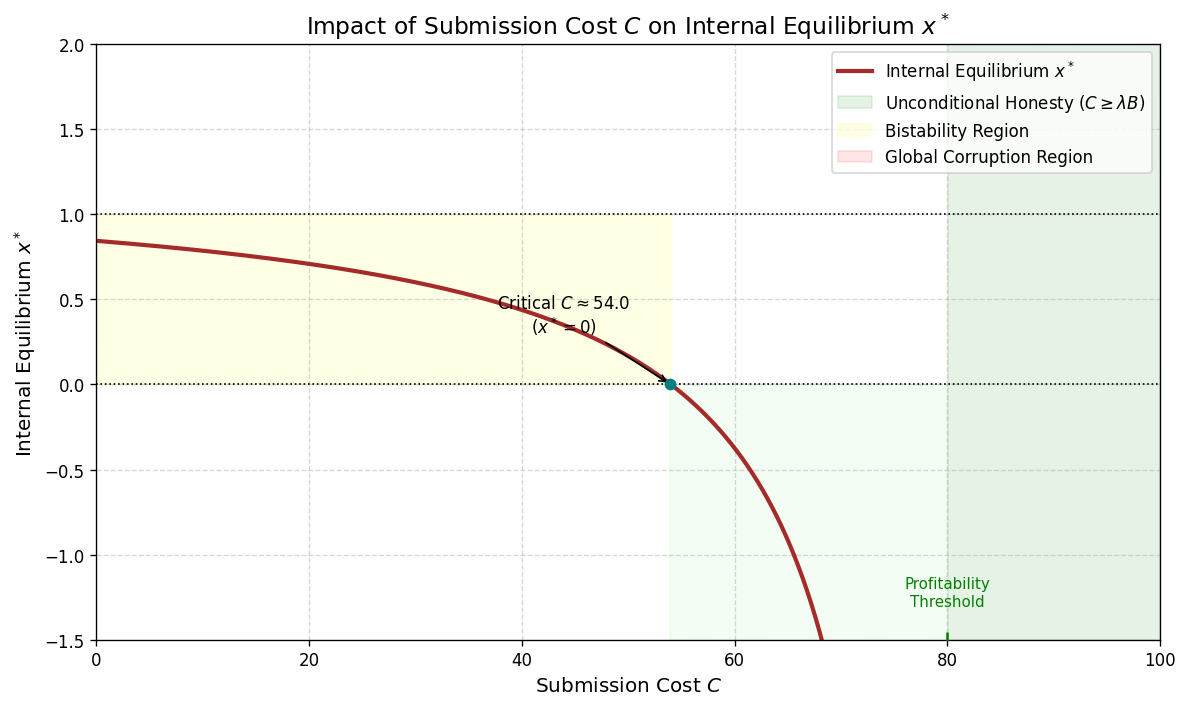

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings (Restored to Defaults)
# ==========================================
params = {
    'epsilon': 0.01,
    'lam': 0.8,
    'N': 1000,      # Default N
    'K': 100,       # Default K
    'alpha': 0.2,   # Probability of producing a good paper
    # 'C': Variable,
    'B': 100,       # Benefit of acceptance
    'D': 50,        # Penalty for rejection
    'C_J': 0.5      # Cost of review per paper
}

# ==========================================
# 2. Mathematical Derivation
# ==========================================
def calculate_x_star_C(C_values, p):
    x_stars = []

    for C in C_values:
        # Profitability of bad paper
        profit = p['lam'] * p['B'] - C

        if profit <= 0:
            # Unconditional Honesty (Cheating is unprofitable)
            x_stars.append(-2.0)
        else:
            numerator = profit
            denominator = p['D'] + p['lam'] * p['B']
            sigma_star = numerator / denominator

            # Critical Volume
            V_crit = (p['K'] / sigma_star - p['epsilon']) / p['C_J']

            # x*
            val = (1 - V_crit / p['N']) / (1 - p['alpha'])
            x_stars.append(val)

    return np.array(x_stars)

# ==========================================
# 3. Generate Data
# ==========================================
# Range of C: 0 to 100
# Threshold is at C = lam * B = 0.8 * 100 = 80
C_range = np.linspace(0, 100, 1000)
x_star_values = calculate_x_star_C(C_range, params)

# Find transition points
# 1. Profitability Threshold (C_max)
C_profit = params['lam'] * params['B']

# 2. Honesty Transition (x* = 0)
# Note: As C increases, x* decreases. So we look for where it crosses 0.
indices_0 = np.where(np.diff(np.sign(x_star_values - 0)))[0]
C_crit_0 = C_range[indices_0[0]] if indices_0.size > 0 else None

# 3. Corruption Transition (x* = 1)
# Note: At low C, x* might be > 1.
indices_1 = np.where(np.diff(np.sign(x_star_values - 1)))[0]
C_crit_1 = C_range[indices_1[0]] if indices_1.size > 0 else None

# ==========================================
# 4. Plotting
# ==========================================
plt.figure(figsize=(10, 6), dpi=120)

plt.plot(C_range, x_star_values, label=r'Internal Equilibrium $x^*$', color='brown', linewidth=2.5)

# Set Limits
plt.ylim(-1.5, 2.0)
plt.xlim(0, 100)

# Highlight Regions
# Unconditional Honesty (C >= 80)
plt.fill_between(C_range, -1.5, 2.0, where=(C_range >= C_profit),
                 color='green', alpha=0.1, label=r'Unconditional Honesty ($C \geq \lambda B$)')

# Capacity-enforced Honesty (x* < 0 but C < 80)
if C_crit_0:
    plt.fill_between(C_range, -1.5, 0, where=(C_range < C_profit) & (C_range >= C_crit_0),
                     color='lightgreen', alpha=0.1)

# Bistability (0 <= x* <= 1)
plt.fill_between(C_range, 0, 1, where=(x_star_values >= 0) & (x_star_values <= 1),
                 color='yellow', alpha=0.1, label='Bistability Region')

# Corruption (x* > 1)
plt.fill_between(C_range, 1, 2.0, where=(x_star_values > 1),
                 color='red', alpha=0.1, label='Global Corruption Region')

plt.axhline(0, color='black', linestyle=':', linewidth=1)
plt.axhline(1, color='black', linestyle=':', linewidth=1)

# Annotations
if C_crit_1:
    plt.scatter([C_crit_1], [1], color='red', zorder=5)
    plt.annotate(f'Critical $C \\approx {C_crit_1:.1f}$\n($x^*=1$)',
                 xy=(C_crit_1, 1), xytext=(C_crit_1 + 5, 1.2),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

if C_crit_0:
    plt.scatter([C_crit_0], [0], color='teal', zorder=5)
    plt.annotate(f'Critical $C \\approx {C_crit_0:.1f}$\n($x^*=0$)',
                 xy=(C_crit_0, 0), xytext=(C_crit_0 - 10, 0.3),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

plt.scatter([C_profit], [-1.5], color='green', zorder=5, marker='|', s=100)
plt.text(C_profit, -1.3, "Profitability\nThreshold", fontsize=9, color='green', ha='center')

plt.title(r'Impact of Submission Cost $C$ on Internal Equilibrium $x^*$', fontsize=14)
plt.xlabel(r'Submission Cost $C$', fontsize=12)
plt.ylabel(r'Internal Equilibrium $x^*$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('C_x.pdf')
plt.show()

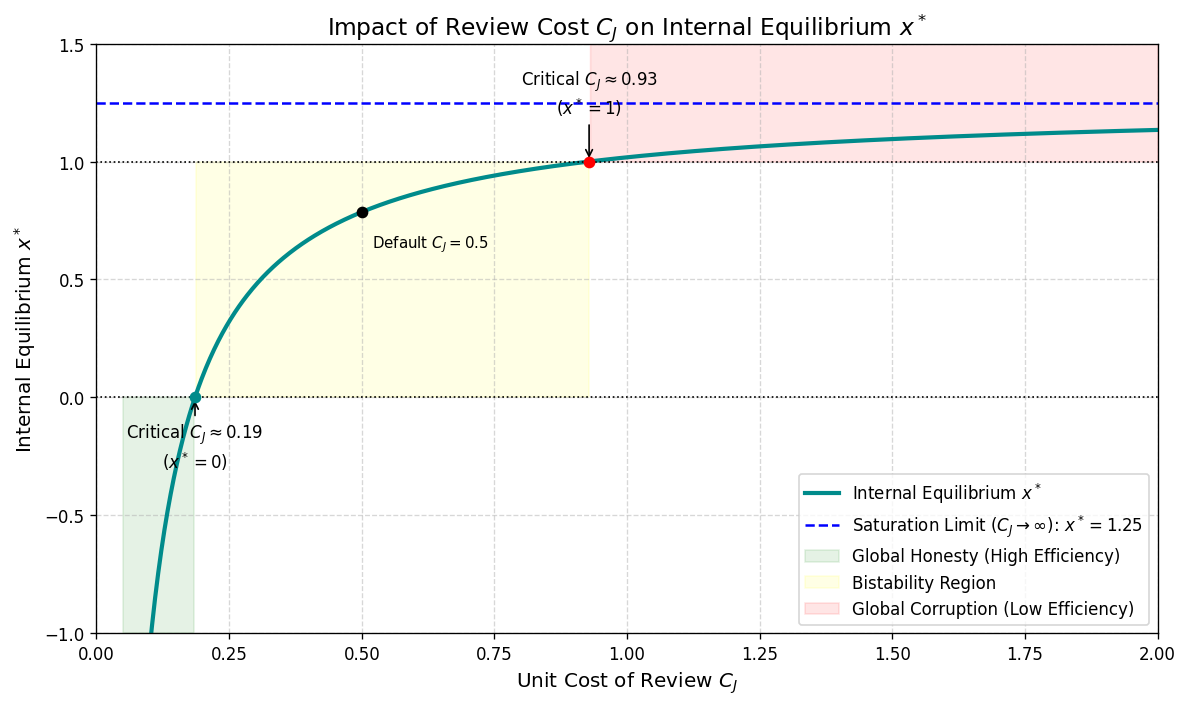

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings (Restored to Defaults)
# ==========================================
params = {
    'epsilon': 0.01,
    'lam': 0.8,
    'N': 1000,      # Default N
    'K': 100,       # Default K
    'alpha': 0.2,   # Probability of producing a good paper
    'C': 10,        # Cost of submission
    'B': 100,       # Benefit of acceptance
    'D': 50,        # Penalty for rejection
    # 'C_J': Variable
}

# ==========================================
# 2. Mathematical Derivation
# ==========================================
# Equilibrium condition: E[U_Bad] = 0
# sigma* = (lam * B - C) / (D + lam * B)
#
# Constraint Equation:
# sigma* = K / (C_J * V(x*) + epsilon)
# => C_J * V(x*) = K/sigma* - epsilon
# => V(x*) = (K/sigma* - epsilon) / C_J
#
# Substitute V(x*) = N * [1 - (1-alpha)x*]:
# N * [1 - (1-alpha)x*] = (K/sigma* - epsilon) / C_J
# 1 - (1-alpha)x* = (K/sigma* - epsilon) / (N * C_J)
#
# Solve for x*:
# x* = (1 / (1-alpha)) * [ 1 - (K/sigma* - epsilon) / (N * C_J) ]

def calculate_x_star_CJ(CJ_values, p):
    # 1. Calculate target sigma (Constant independent of CJ)
    numerator = p['lam'] * p['B'] - p['C']
    denominator = p['D'] + p['lam'] * p['B']
    sigma_star = numerator / denominator

    # 2. Calculate the "Capacity Factor" A
    # A = (K/sigma* - epsilon) / N
    # This represents the per-capita available screening resource (unscaled by cost)
    A = (p['K'] / sigma_star - p['epsilon']) / p['N']

    # 3. Calculate x* for each CJ
    # x* = (1 - A/CJ) / (1 - alpha)
    x_stars = (1 - A / CJ_values) / (1 - p['alpha'])

    return x_stars

# ==========================================
# 3. Generate Data
# ==========================================
# Range of CJ: 0.05 to 2.0 (Default is 0.5)
CJ_range = np.linspace(0.05, 2.0, 1000)
x_star_values = calculate_x_star_CJ(CJ_range, params)

# Calculate Asymptote as CJ -> infinity
# The term A/CJ -> 0, so x* -> 1/(1-alpha)
asymptote = 1 / (1 - params['alpha']) # = 1.25

# Find Transition Points
# 1. Honesty Transition (x* = 0)
# 1 - A/CJ = 0 => CJ = A
numerator = params['lam'] * params['B'] - params['C']
denominator = params['D'] + params['lam'] * params['B']
sigma_star = numerator / denominator
A = (params['K'] / sigma_star - params['epsilon']) / params['N']

CJ_crit_0 = A

# 2. Corruption Transition (x* = 1)
# (1 - A/CJ)/(1-alpha) = 1 => 1 - A/CJ = 1 - alpha => A/CJ = alpha => CJ = A/alpha
CJ_crit_1 = A / params['alpha']

# ==========================================
# 4. Plotting
# ==========================================
plt.figure(figsize=(10, 6), dpi=120)

plt.plot(CJ_range, x_star_values, label=r'Internal Equilibrium $x^*$', color='darkcyan', linewidth=2.5)
plt.axhline(asymptote, color='blue', linestyle='--', label=f'Saturation Limit ($C_J \\to \\infty$): $x^*={asymptote}$')

# Set Limits
plt.ylim(-1.0, 1.5)
plt.xlim(0, 2.0)

# Highlight Regions
# Global Honesty (x* < 0)
plt.fill_between(CJ_range, -1.0, 0, where=(x_star_values < 0),
                 color='green', alpha=0.1, label='Global Honesty (High Efficiency)')

# Bistability (0 <= x* <= 1)
plt.fill_between(CJ_range, 0, 1, where=(x_star_values >= 0) & (x_star_values <= 1),
                 color='yellow', alpha=0.1, label='Bistability Region')

# Global Corruption (x* > 1)
plt.fill_between(CJ_range, 1, 1.5, where=(x_star_values > 1),
                 color='red', alpha=0.1, label='Global Corruption (Low Efficiency)')

plt.axhline(0, color='black', linestyle=':', linewidth=1)
plt.axhline(1, color='black', linestyle=':', linewidth=1)

# Annotations
plt.scatter([CJ_crit_0], [0], color='darkcyan', zorder=5)
plt.annotate(f'Critical $C_J \\approx {CJ_crit_0:.2f}$\n($x^*=0$)',
             xy=(CJ_crit_0, 0), xytext=(CJ_crit_0, -0.3),
             arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

plt.scatter([CJ_crit_1], [1], color='red', zorder=5)
plt.annotate(f'Critical $C_J \\approx {CJ_crit_1:.2f}$\n($x^*=1$)',
             xy=(CJ_crit_1, 1), xytext=(CJ_crit_1, 1.2),
             arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

plt.scatter([0.5], [calculate_x_star_CJ(np.array([0.5]), params)[0]], color='black', zorder=5)
plt.text(0.52, calculate_x_star_CJ(np.array([0.5]), params)[0] - 0.15, "Default $C_J=0.5$", fontsize=9)

plt.title(r'Impact of Review Cost $C_J$ on Internal Equilibrium $x^*$', fontsize=14)
plt.xlabel(r'Unit Cost of Review $C_J$', fontsize=12)
plt.ylabel(r'Internal Equilibrium $x^*$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('CJ_x.pdf')
plt.show()

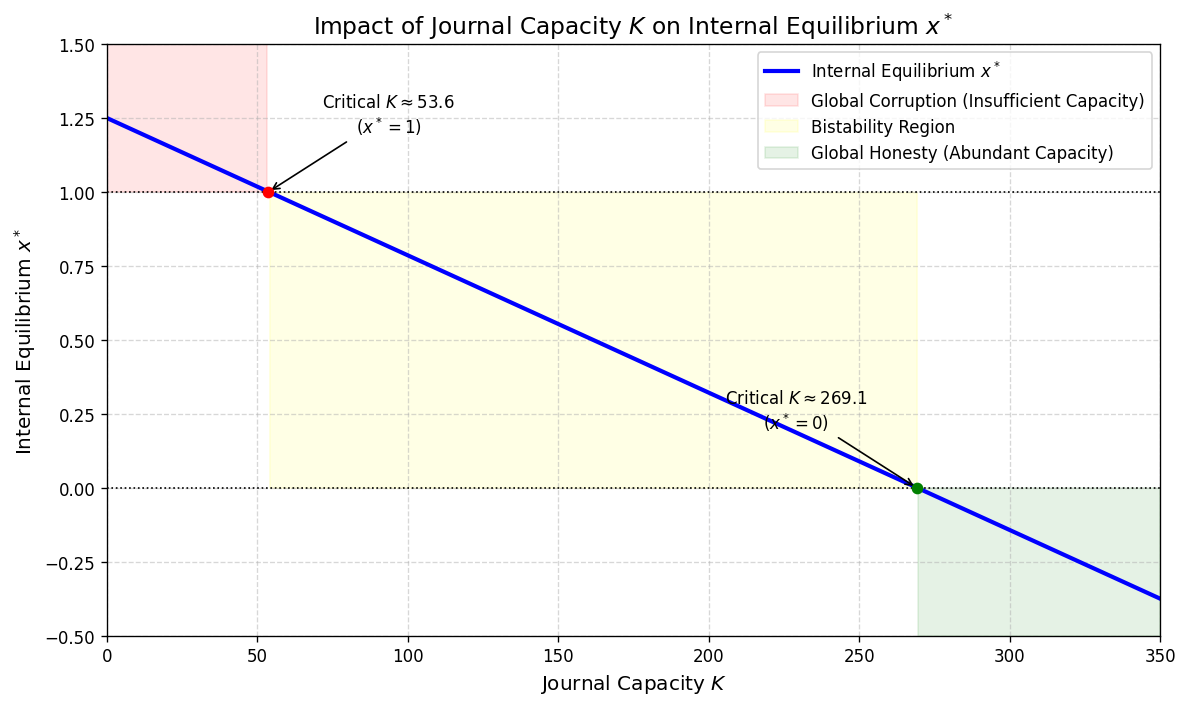

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings (Restored to Defaults)
# ==========================================
params = {
    'epsilon': 0.01,
    'lam': 0.8,
    'N': 1000,      # Default N
    # 'K': Variable,
    'alpha': 0.2,   # Probability of producing a good paper
    'C': 10,        # Cost of submission
    'B': 100,       # Benefit of acceptance
    'D': 50,        # Penalty for rejection
    'C_J': 0.5      # Cost of review per paper
}

# ==========================================
# 2. Mathematical Derivation
# ==========================================
# Equilibrium condition: E[U_Bad] = 0
# sigma* = (lam * B - C) / (D + lam * B)
#
# Constraint Equation:
# sigma* = K / (C_J * V(x*) + epsilon)
# => V(x*) = (K/sigma* - epsilon) / C_J
#
# Substitute V(x*) = N * [1 - (1-alpha)x*]:
# x* = (1 / (1-alpha)) * [ 1 - (K/sigma* - epsilon) / (N * C_J) ]

def calculate_x_star_K(K_values, p):
    # 1. Calculate target sigma (Constant)
    numerator = p['lam'] * p['B'] - p['C']
    denominator = p['D'] + p['lam'] * p['B']
    sigma_star = numerator / denominator

    # 2. Calculate x* for each K
    # x* = A - B * K  (Linear relationship)
    # Let's compute directly
    term1 = 1 / (1 - p['alpha'])
    term2_denom = p['N'] * p['C_J']

    x_stars = []
    for k in K_values:
        term_bracket = (k / sigma_star - p['epsilon']) / term2_denom
        val = term1 * (1 - term_bracket)
        x_stars.append(val)

    return np.array(x_stars)

# ==========================================
# 3. Generate Data
# ==========================================
# Range of K: 0 to 350
K_range = np.linspace(0, 350, 1000)
x_star_values = calculate_x_star_K(K_range, params)

# Find Transition Points
# 1. Corruption Transition (x* = 1)
# Occurs at K_low
indices_1 = np.where(np.diff(np.sign(x_star_values - 1)))[0]
K_crit_1 = K_range[indices_1[0]] if indices_1.size > 0 else None

# 2. Honesty Transition (x* = 0)
# Occurs at K_high
indices_0 = np.where(np.diff(np.sign(x_star_values - 0)))[0]
K_crit_0 = K_range[indices_0[0]] if indices_0.size > 0 else None

# ==========================================
# 4. Plotting
# ==========================================
plt.figure(figsize=(10, 6), dpi=120)

plt.plot(K_range, x_star_values, label=r'Internal Equilibrium $x^*$', color='blue', linewidth=2.5)

# Set Limits
plt.ylim(-0.5, 1.5)
plt.xlim(0, 350)

# Highlight Regions
# Global Corruption (x* > 1) -> Low K
if K_crit_1:
    plt.fill_between(K_range, 1, 1.5, where=(K_range < K_crit_1),
                     color='red', alpha=0.1, label='Global Corruption (Insufficient Capacity)')

# Bistability (0 <= x* <= 1) -> Medium K
plt.fill_between(K_range, 0, 1, where=(x_star_values >= 0) & (x_star_values <= 1),
                 color='yellow', alpha=0.1, label='Bistability Region')

# Global Honesty (x* < 0) -> High K
if K_crit_0:
    plt.fill_between(K_range, -0.5, 0, where=(K_range > K_crit_0),
                     color='green', alpha=0.1, label='Global Honesty (Abundant Capacity)')

plt.axhline(0, color='black', linestyle=':', linewidth=1)
plt.axhline(1, color='black', linestyle=':', linewidth=1)

# Annotations
if K_crit_1:
    plt.scatter([K_crit_1], [1], color='red', zorder=5)
    plt.annotate(f'Critical $K \\approx {K_crit_1:.1f}$\n($x^*=1$)',
                 xy=(K_crit_1, 1), xytext=(K_crit_1 + 40, 1.2),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

if K_crit_0:
    plt.scatter([K_crit_0], [0], color='green', zorder=5)
    plt.annotate(f'Critical $K \\approx {K_crit_0:.1f}$\n($x^*=0$)',
                 xy=(K_crit_0, 0), xytext=(K_crit_0 - 40, 0.2),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), ha='center')

plt.title(r'Impact of Journal Capacity $K$ on Internal Equilibrium $x^*$', fontsize=14)
plt.xlabel(r'Journal Capacity $K$', fontsize=12)
plt.ylabel(r'Internal Equilibrium $x^*$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('K_x_analysis.pdf')
plt.show()

Calculating Average Quality Heatmap...
Calculation complete.


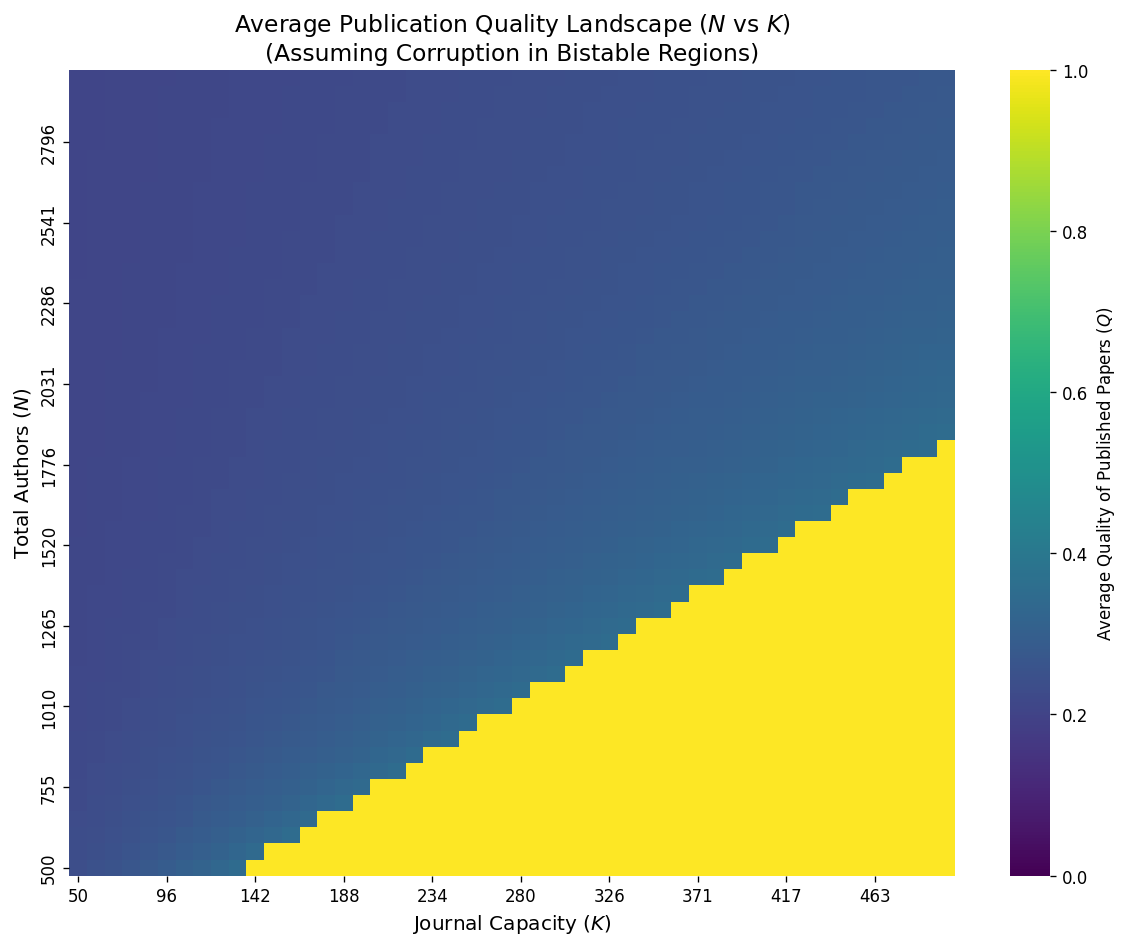

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ==========================================
# 1. Parameter Settings
# ==========================================
params = {
    'epsilon': 0.01,
    'lam': 0.8,     # Probability/Return rate for bad papers
    'alpha': 0.2,   # Natural proportion of good papers
    'C': 10,        # Cost of submission
    'B': 100,       # Benefit of acceptance
    'D': 50,        # Penalty for rejection
    'C_J': 0.5      # Cost of review per paper
}

# ==========================================
# 2. Quality Calculation Function
# ==========================================
def calculate_average_quality(N, K, p, state='honest'):
    """
    Calculates the average quality of accepted papers (0 to 1).
    Formula: Quality = Accepted_Good / (Accepted_Good + Accepted_Bad)

    Parameters:
    state: 'honest' (implies x=1) or 'corrupt' (implies x=0)
    """
    # 1. Determine Submission Volumes based on state
    if state == 'honest':
        # Honest state: Only Good papers are submitted
        # V_total = N * alpha
        V_bad_submitted = 0
        V_good_submitted = N * p['alpha']
    else:
        # Corrupt state: Everyone submits everything (Good + Bad)
        # V_total = N
        V_bad_submitted = N * (1 - p['alpha'])
        V_good_submitted = N * p['alpha']

    V_total = V_good_submitted + V_bad_submitted

    # 2. Calculate Actual Screening Probability (sigma)
    # Note: K is passed as an argument here, not from params
    if V_total > 0:
        sigma = K / (p['C_J'] * V_total + p['epsilon'])
    else:
        sigma = 1.0

    # Physical constraint: 0 <= sigma <= 1
    sigma = np.clip(sigma, 0, 1)

    # 3. Calculate Accepted Volumes
    # Assumption: Good papers are always accepted if reviewed
    Acc_good = V_good_submitted

    # Assumption: Bad papers are accepted only if they slip through screening (1 - sigma)
    Acc_bad = V_bad_submitted * (1 - sigma)

    # 4. Calculate Average Quality ratio
    total_accepted = Acc_good + Acc_bad

    if total_accepted == 0:
        return 0.0

    quality = Acc_good / total_accepted
    return quality

def get_system_state_quality(N, K, p):
    """
    Determines the system's stability regime and calculates resulting quality.

    Logic:
    1. Calculate x* (Tipping Point).
    2. If x* < 0: Global Honesty -> High Quality.
    3. If x* > 1: Global Corruption -> Low Quality.
    4. If 0 <= x* <= 1: Bistability -> Assume Worst Case (Corruption) -> Low Quality.
    """
    # Profitability check
    profit = p['lam'] * p['B'] - p['C']
    if profit <= 0:
        # Cheating is irrational -> Always Honest
        return calculate_average_quality(N, K, p, state='honest')

    # Calculate target sigma* required for equilibrium
    sigma_star = profit / (p['D'] + p['lam'] * p['B'])

    # Calculate Critical Volume allowed for this sigma*
    # V(x*) = (K/sigma* - epsilon) / C_J
    term = (K / sigma_star - p['epsilon']) / p['C_J']

    # Calculate x* based on N
    # x* = (1 - V_allowed/N) / (1-alpha)
    if N == 0: return 0
    x_star = (1 - term / N) / (1 - p['alpha'])

    # Determine State and Quality
    if x_star < 0:
        # Global Honesty Region
        return calculate_average_quality(N, K, p, state='honest')
    elif x_star > 1:
        # Global Corruption Region
        return calculate_average_quality(N, K, p, state='corrupt')
    else:
        # Bistability Region
        # We assume the "Worst Case" (Corruption) to highlight the risk of congestion
        return calculate_average_quality(N, K, p, state='corrupt')

# ==========================================
# 3. Simulation Loop
# ==========================================
# Define Ranges
N_values = np.linspace(500, 3000, 50)  # Author Population
K_values = np.linspace(50, 500, 50)    # Journal Capacity

results_matrix = np.zeros((len(N_values), len(K_values)))

print("Calculating Average Quality Heatmap...")
for i, n_val in enumerate(N_values):
    for j, k_val in enumerate(K_values):
        # Pass current n_val and k_val to the logic function
        q = get_system_state_quality(n_val, k_val, params)
        results_matrix[i, j] = q

print("Calculation complete.")

# ==========================================
# 4. Visualization
# ==========================================
plt.figure(figsize=(10, 8), dpi=120)

# Create DataFrame for Seaborn
# Indexes are N (Y-axis), Columns are K (X-axis)
df_results = pd.DataFrame(
    results_matrix,
    index=np.round(N_values).astype(int),
    columns=np.round(K_values).astype(int)
)

# Plot Heatmap
# Using 'viridis' for a smooth, academic gradient (Purple=Low Quality, Yellow=High Quality)
sns.heatmap(
    df_results,
    cmap="viridis",
    vmin=0, vmax=1, # Quality is strictly between 0 and 1
    cbar_kws={'label': 'Average Quality of Published Papers ($Q$)'},
    xticklabels=5,
    yticklabels=5
)

# Axis Labels and Title
plt.title(r'Average Publication Quality Landscape ($N$ vs $K$)' + '\n' + r'(Assuming Corruption in Bistable Regions)', fontsize=14)
plt.xlabel(r'Journal Capacity ($K$)', fontsize=12)
plt.ylabel(r'Total Authors ($N$)', fontsize=12)

# Invert Y-axis so smallest N is at the bottom (Cartesian style)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('Quality_Heatmap_Viridis.pdf')
plt.show()

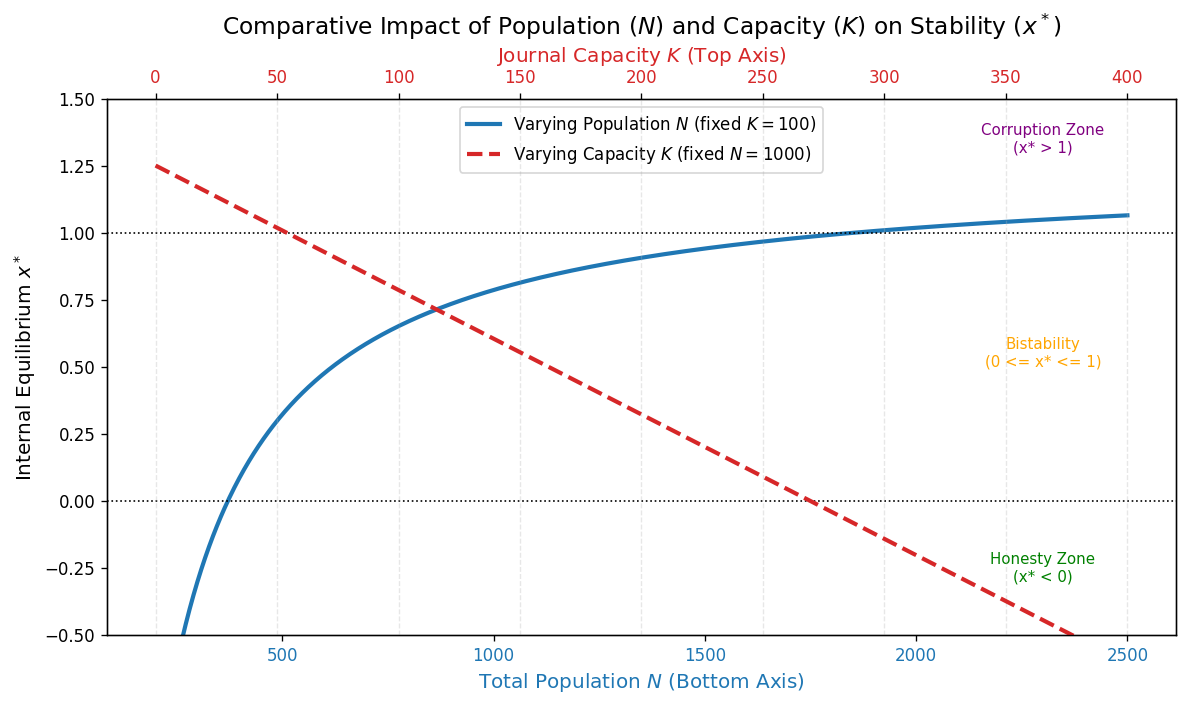

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings
# ==========================================
params = {
    'epsilon': 0.01,
    'lam': 0.8,
    'alpha': 0.2,
    'C': 10,
    'B': 100,
    'D': 50,
    'C_J': 0.5,
    'N_default': 1000,
    'K_default': 100
}

# ==========================================
# 2. Calculation Functions
# ==========================================
def calculate_x_star_N(N_values, p):
    # Fixed K
    K = p['K_default']

    # Target sigma
    sigma_star = (p['lam'] * p['B'] - p['C']) / (p['D'] + p['lam'] * p['B'])

    # Critical volume allowed by capacity K
    V_crit = (K / sigma_star - p['epsilon']) / p['C_J']

    # x* = (1 - V_crit / N) / (1 - alpha)
    x_stars = (1 - V_crit / N_values) / (1 - p['alpha'])
    return x_stars

def calculate_x_star_K(K_values, p):
    # Fixed N
    N = p['N_default']

    # Target sigma
    sigma_star = (p['lam'] * p['B'] - p['C']) / (p['D'] + p['lam'] * p['B'])

    # x* depends linearly on K
    term1 = 1 / (1 - p['alpha'])
    term2_denom = N * p['C_J']

    # (K/sigma* - epsilon) / (N * C_J)
    term_bracket = (K_values / sigma_star - p['epsilon']) / term2_denom
    x_stars = term1 * (1 - term_bracket)
    return x_stars

# ==========================================
# 3. Generate Data
# ==========================================
# Range for N (Total Population)
N_range = np.linspace(200, 2500, 1000)
x_N = calculate_x_star_N(N_range, params)

# Range for K (Journal Capacity)
K_range = np.linspace(0, 400, 1000)
x_K = calculate_x_star_K(K_range, params)

# ==========================================
# 4. Plotting (Dual X-Axis)
# ==========================================
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=120)

# Plot N on the bottom axis (Blue)
color_N = 'tab:blue'
ax1.set_xlabel('Total Population $N$ (Bottom Axis)', color=color_N, fontsize=12)
ax1.plot(N_range, x_N, color=color_N, linewidth=2.5, label=r'Varying Population $N$ (fixed $K=100$)')
ax1.tick_params(axis='x', labelcolor=color_N)
ax1.set_ylabel(r'Internal Equilibrium $x^*$', fontsize=12)
ax1.set_ylim(-0.5, 1.5)

# Create a second x-axis for K (Red)
ax2 = ax1.twiny()
color_K = 'tab:red'
ax2.set_xlabel('Journal Capacity $K$ (Top Axis)', color=color_K, fontsize=12)
ax2.plot(K_range, x_K, color=color_K, linewidth=2.5, linestyle='--', label=r'Varying Capacity $K$ (fixed $N=1000$)')
ax2.tick_params(axis='x', labelcolor=color_K)

# Add horizontal reference lines
ax1.axhline(0, color='black', linestyle=':', linewidth=1)
ax1.axhline(1, color='black', linestyle=':', linewidth=1)

# Combined Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', frameon=True, fontsize=10)

# Annotations for Critical Regions (Text Only)
ax1.text(2300, 1.3, "Corruption Zone\n(x* > 1)", color='purple', ha='center', fontsize=9)
ax1.text(2300, -0.3, "Honesty Zone\n(x* < 0)", color='green', ha='center', fontsize=9)
ax1.text(2300, 0.5, "Bistability\n(0 <= x* <= 1)", color='orange', ha='center', fontsize=9)

plt.title(r'Comparative Impact of Population ($N$) and Capacity ($K$) on Stability ($x^*$)', fontsize=14, y=1.1)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('combined_NK_plot.pdf')
plt.show()

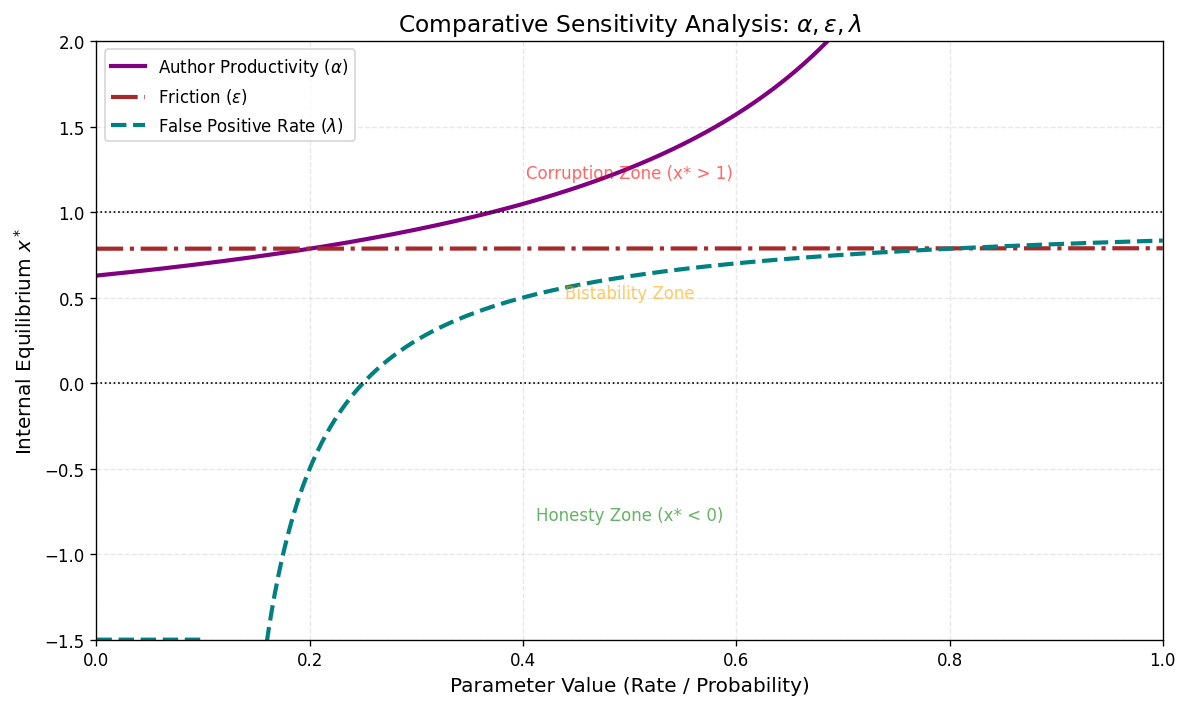

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings
# ==========================================
params = {
    'epsilon': 0.01,
    'lam': 0.8,
    'alpha': 0.2,
    'C': 10,
    'B': 100,
    'D': 50,
    'C_J': 0.5,
    'N': 1000,
    'K': 100
}

# ==========================================
# 2. Calculation Functions
# ==========================================

# 2.1 Calculate x* varying alpha (Author Productivity)
def calculate_x_star_alpha(alpha_values, p):
    # Target sigma (constant)
    sigma_star = (p['lam'] * p['B'] - p['C']) / (p['D'] + p['lam'] * p['B'])

    # Critical volume A (constant)
    A = (p['K'] / sigma_star - p['epsilon']) / p['C_J']

    # x* = (1 - A/N) / (1 - alpha)
    # A/N is constant
    term = 1 - A / p['N']

    # Avoid division by zero at alpha=1
    x_stars = term / (1 - alpha_values)
    return x_stars

# 2.2 Calculate x* varying epsilon (Friction)
def calculate_x_star_epsilon(eps_values, p):
    # Target sigma (constant)
    sigma_star = (p['lam'] * p['B'] - p['C']) / (p['D'] + p['lam'] * p['B'])

    # A varies with epsilon
    # A(eps) = (K/sigma* - eps) / C_J
    # x* = (1 - A(eps)/N) / (1 - alpha)

    term1 = 1 / (1 - p['alpha'])
    NCJ = p['N'] * p['C_J']
    K_over_sigma = p['K'] / sigma_star

    x_stars = []
    for eps in eps_values:
        # x* = (1 - (K/sigma - eps)/(N*CJ)) / (1-alpha)
        val = (1 - (K_over_sigma - eps)/NCJ) / (1 - p['alpha'])
        x_stars.append(val)

    return np.array(x_stars)

# 2.3 Calculate x* varying lambda (False Positive Rate)
def calculate_x_star_lambda(lam_values, p):
    x_stars = []

    for lam in lam_values:
        # Profitability check
        profit = lam * p['B'] - p['C']

        if profit <= 0:
            # Unconditional Honesty region
            # We clamp to -1.5 for visualization
            x_stars.append(-1.5)
        else:
            # Target sigma varies with lambda
            sigma_star = profit / (p['D'] + lam * p['B'])

            # Volume allowed varies with sigma*
            # V = (K/sigma* - epsilon) / C_J
            V_allowed = (p['K'] / sigma_star - p['epsilon']) / p['C_J']

            # x*
            val = (1 - V_allowed / p['N']) / (1 - p['alpha'])
            x_stars.append(val)

    return np.array(x_stars)

# ==========================================
# 3. Generate Data
# ==========================================
x_range = np.linspace(0, 1, 1000)

# Limit alpha range to 0.95 to avoid asymptote
alpha_range = np.linspace(0, 0.95, 1000)
x_vals_alpha = calculate_x_star_alpha(alpha_range, params)

# Epsilon full range 0-1
eps_range = np.linspace(0, 1, 1000)
x_vals_eps = calculate_x_star_epsilon(eps_range, params)

# Lambda full range 0-1
lam_range = np.linspace(0, 1, 1000)
x_vals_lam = calculate_x_star_lambda(lam_range, params)


# ==========================================
# 4. Plotting
# ==========================================
plt.figure(figsize=(10, 6), dpi=120)

# Plot curves
plt.plot(alpha_range, x_vals_alpha, label=r'Author Productivity ($\alpha$)', color='purple', linewidth=2.5)
plt.plot(eps_range, x_vals_eps, label=r'Friction ($\epsilon$)', color='brown', linewidth=2.5, linestyle='-.')
plt.plot(lam_range, x_vals_lam, label=r'False Positive Rate ($\lambda$)', color='teal', linewidth=2.5, linestyle='--')

# Critical Boundaries
plt.axhline(0, color='black', linestyle=':', linewidth=1)
plt.axhline(1, color='black', linestyle=':', linewidth=1)

# Annotations (Regions)
plt.text(0.5, 1.2, "Corruption Zone (x* > 1)", color='red', fontsize=10, ha='center', alpha=0.6)
plt.text(0.5, 0.5, "Bistability Zone", color='orange', fontsize=10, ha='center', alpha=0.6)
plt.text(0.5, -0.8, "Honesty Zone (x* < 0)", color='green', fontsize=10, ha='center', alpha=0.6)

# Labels
plt.title(r'Comparative Sensitivity Analysis: $\alpha, \epsilon, \lambda$', fontsize=14)
plt.xlabel(r'Parameter Value (Rate / Probability)', fontsize=12)
plt.ylabel(r'Internal Equilibrium $x^*$', fontsize=12)

# Limits
plt.ylim(-1.5, 2.0)
plt.xlim(0, 1.0)

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('combined_sensitivity_analysis.pdf')
plt.show()

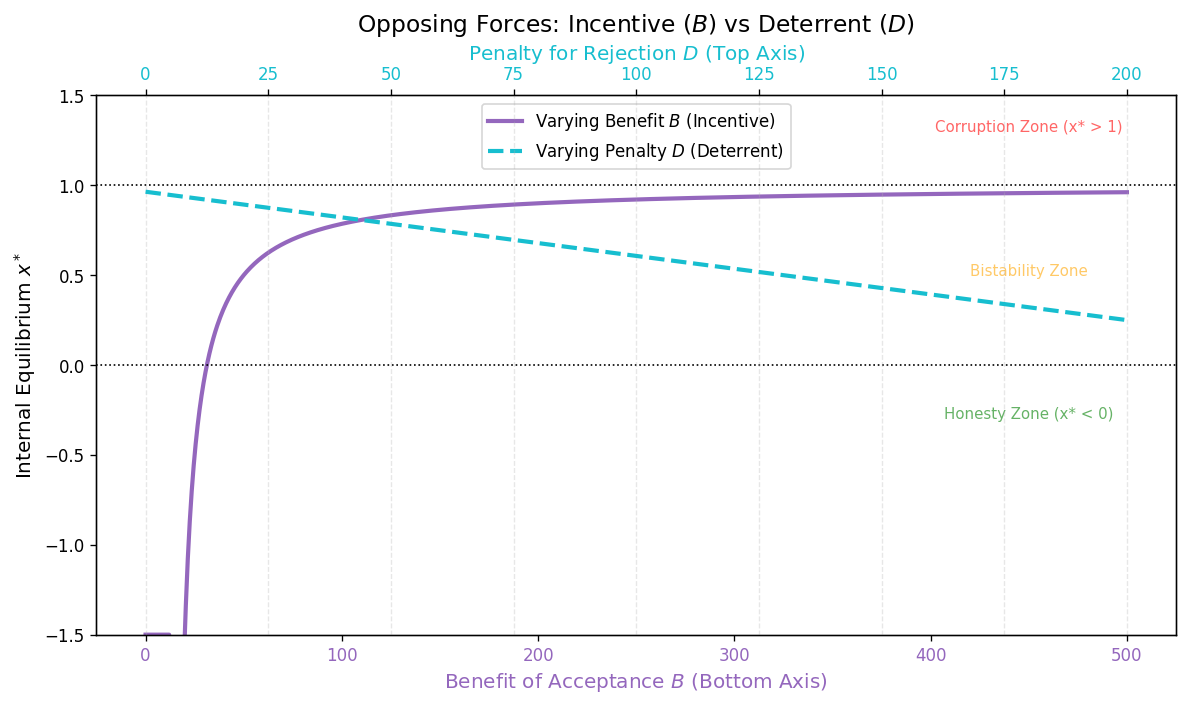

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Parameter Settings
# ==========================================
params = {
    'epsilon': 0.01,
    'lam': 0.8,
    'alpha': 0.2,
    'C': 10,
    'B_default': 100,  # For varying D
    'D_default': 50,   # For varying B
    'C_J': 0.5,
    'N': 1000,
    'K': 100
}

# ==========================================
# 2. Calculation Functions
# ==========================================
def calculate_x_star_B(B_values, p):
    x_stars = []

    for B in B_values:
        # Profitability check: lam * B - C
        profit = p['lam'] * B - p['C']

        if profit <= 0:
            x_stars.append(-1.5) # Unconditional Honesty (Clamped)
        else:
            # Fixed D
            D = p['D_default']
            numerator = profit
            denominator = D + p['lam'] * B
            sigma_star = numerator / denominator

            # Critical Volume
            V_crit = (p['K'] / sigma_star - p['epsilon']) / p['C_J']

            # x*
            val = (1 - V_crit / p['N']) / (1 - p['alpha'])
            x_stars.append(val)

    return np.array(x_stars)

def calculate_x_star_D(D_values, p):
    x_stars = []

    # Fixed B
    B = p['B_default']
    profit = p['lam'] * B - p['C']

    # Profit is constant and positive (0.8*100 - 10 = 70 > 0)
    # So we don't need to check profit <= 0 inside loop unless B changes

    for D in D_values:
        numerator = profit
        denominator = D + p['lam'] * B
        sigma_star = numerator / denominator

        # Critical Volume
        V_crit = (p['K'] / sigma_star - p['epsilon']) / p['C_J']

        # x*
        val = (1 - V_crit / p['N']) / (1 - p['alpha'])
        x_stars.append(val)

    return np.array(x_stars)

# ==========================================
# 3. Generate Data
# ==========================================
# Range for B (Incentive): 0 to 500
B_range = np.linspace(0, 500, 1000)
x_B = calculate_x_star_B(B_range, params)

# Range for D (Deterrent): 0 to 200
D_range = np.linspace(0, 200, 1000)
x_D = calculate_x_star_D(D_range, params)

# ==========================================
# 4. Plotting (Dual X-Axis)
# ==========================================
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=120)

# Plot B on the bottom axis (Purple)
color_B = 'tab:purple'
ax1.set_xlabel('Benefit of Acceptance $B$ (Bottom Axis)', color=color_B, fontsize=12)
ax1.plot(B_range, x_B, color=color_B, linewidth=2.5, label=r'Varying Benefit $B$ (Incentive)')
ax1.tick_params(axis='x', labelcolor=color_B)
ax1.set_ylabel(r'Internal Equilibrium $x^*$', fontsize=12)
ax1.set_ylim(-1.5, 1.5)

# Create a second x-axis for D (Teal)
ax2 = ax1.twiny()
color_D = 'tab:cyan' # Teal-ish
ax2.set_xlabel('Penalty for Rejection $D$ (Top Axis)', color=color_D, fontsize=12)
ax2.plot(D_range, x_D, color=color_D, linewidth=2.5, linestyle='--', label=r'Varying Penalty $D$ (Deterrent)')
ax2.tick_params(axis='x', labelcolor=color_D)

# Add horizontal reference lines
ax1.axhline(0, color='black', linestyle=':', linewidth=1)
ax1.axhline(1, color='black', linestyle=':', linewidth=1)

# Combined Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', frameon=True, fontsize=10)

# Annotations (Simplified Text)
ax1.text(450, 1.3, "Corruption Zone (x* > 1)", color='red', ha='center', fontsize=9, alpha=0.6)
ax1.text(450, -0.3, "Honesty Zone (x* < 0)", color='green', ha='center', fontsize=9, alpha=0.6)
ax1.text(450, 0.5, "Bistability Zone", color='orange', ha='center', fontsize=9, alpha=0.6)

plt.title(r'Opposing Forces: Incentive ($B$) vs Deterrent ($D$)', fontsize=14, y=1.1)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('combined_BD_plot.pdf')
plt.show()